In [1]:
TRAIN_ALL = True
TRAIN_BEST = True

In [2]:
from IPython.display import display, Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.utils import class_weight

from keras import initializers, optimizers
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Conv1D, Dense, Dropout, Flatten, MaxPooling1D, CuDNNLSTM
from keras.models import Sequential, load_model, model_from_json
from keras.utils import plot_model, to_categorical

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import itertools
import keras
import time
import os

Using TensorFlow backend.


## Utilities

In [3]:
def plot_confusion_matrix(cm, class_labels, model_name, cmap=plt.cm.Blues):
    diagram_dir = os.path.join(os.getcwd(), "images")
    if not os.path.exists(diagram_dir):
        os.makedirs(diagram_dir)
    
    stats_dir = os.path.join(os.getcwd(), "stats")
    if not os.path.exists(stats_dir):
        os.makedirs(stats_dir)
    
    # create the figure
    fig = plt.figure()
    fig.set_size_inches(18,15)
    
    # labels
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
    # tick marks
    class_count = len(class_labels)
    tick_marks = np.arange(class_count + 1)
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    # normalization
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, 6)
    
    # numbers
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")
    
    # color bar
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    # save and show
    np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})
    plt.savefig(os.path.join(diagram_dir, model_name + "_confusion_matrix.png"), dpi=100)
    pd.DataFrame(cm).to_csv(os.path.join(stats_dir, model_name + "_confusion_matrix.txt"), header=None, index=None)
    plt.show(block=False)
    

def graph_history(history, model_name, validation_data=False):
    directory = os.path.join(os.getcwd(), "images")
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # summarize history for accuracy
    fig = plt.figure()
    plt.plot(history.history["acc"], linestyle="-", color="k")
    
    if validation_data:
        plt.plot(history.history["val_acc"], linestyle="--", color="grey")
        plt.legend(["Tr. Acc", "Val. Acc"])
    
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.savefig(os.path.join(directory, model_name + "_history_accuracy.png"), dpi=100)
    plt.show()
 
    # summarize history for loss
    fig = plt.figure()
    plt.plot(history.history["loss"], linestyle="-", color="k")
    
    if validation_data:
        plt.plot(history.history["val_loss"], linestyle="--", color="grey")
        plt.legend(["Tr. Loss", "Val. Loss"])
    
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.savefig(os.path.join(directory, model_name + "_history_loss.png"), dpi=100)
    plt.show()

    
def save_model(model, model_name):
    directory = os.path.join(os.getcwd(), "models")
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # save architecture
    with open(os.path.join(directory, model_name + ".json"), "w+") as f:
        f.write(model.to_json())
    
    # save weights
    model.save_weights(os.path.join(directory, model_name + "_weights.h5"))

def load_model(model_name):
    directory = os.path.join(os.getcwd(), "models")

    if os.path.exists(directory):
        # load the architecture
        json_file = open(os.path.join(directory, model_name + ".json"))
        model = model_from_json(json_file.read())
        model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
        json_file.close()

        # load the weights and return the model
        model.load_weights(os.path.join(directory, model_name + "_weights.h5"))
        return model

## Load data

In [6]:
# how long does this take?
start = time.time()

filename = "../../snapshots/unfiltered_snapshots.csv"

# read the file with all dtypes
col_names = pd.read_csv(filename, nrows=0).columns
types_dict = {"Vehicle": int, "Capture": int}
types_dict.update({col: int for col in col_names if col not in types_dict})
df = pd.read_csv(filename, dtype=types_dict)

display(df.sample(frac=0.0001).head(5))
print("Elapsed time: {:.2f} seconds".format(time.time() - start))

Vehicle  Capture  Data 1  Data 2  Data 3  Data 4  Data 5  Data 6  \
222127        7       23      97     244       9     245     224       0   
208621        5       21     192       0     255     253       0     253   
55755         3        8       0      12      32     194      51     110   
157037        4       19      79     160     166      21     105      62   
53041         3        8      19     250     154       0       0       0   

        Data 7  Data 8  ...  Data 1015  Data 1016  Data 1017  Data 1018  \
222127     128       0  ...          0          0          8          0   
208621       0      68  ...          0        128          0         10   
55755        0     226  ...         11          0          0          0   
157037      90       0  ...         22        187        225          7   
53041        0       5  ...          0         32         81          0   

        Data 1019  Data 1020  Data 1021  Data 1022  Data 1023  Data 1024  
222127          7          0          0          0          0          0  
208621         11         67         48         10        200         34  
55755         187          7          0          0          0          1  
157037        125         96          0        236          0          0  
53041           0          0        187          8          0          0  

[5 rows x 1026 columns]

Elapsed time: 29.65 seconds


In [7]:
# relabel the vehicles
new_labels = {v: i for i, v in enumerate(df["Vehicle"].unique())}
old_labels = {i: v for i, v in enumerate(df["Vehicle"].unique())}

df["Vehicle"] = df["Vehicle"].map(new_labels)
display(df.sample(frac=0.0001).head(5))

Vehicle  Capture  Data 1  Data 2  Data 3  Data 4  Data 5  Data 6  \
248713        6       30       1     244      26     208       6     246   
29531         2        5      85     106     111       0       0       0   
298018       19      111     255      50       0       0     254      58   
205023        4       21     144       0       0       0       0     117   
193920        4       21     164       0      34       0       6      32   

        Data 7  Data 8  ...  Data 1015  Data 1016  Data 1017  Data 1018  \
248713       1     242  ...         48          0          1        246   
29531        0       0  ...         29          0          0          8   
298018     219      11  ...        128         17          0         10   
205023     113     113  ...          0          0          0          0   
193920      10      22  ...        155         64          0        127   

        Data 1019  Data 1020  Data 1021  Data 1022  Data 1023  Data 1024  
248713          2         91          4         24        130         44  
29531           6          0          0          7        254          0  
298018        105          0         25          0          0         97  
205023          0          0         35        160         10         20  
193920        255          0        255          0         43        172  

[5 rows x 1026 columns]

## Separate the data

In [8]:
"""
All vehicles
"""

# split into (x, y) sets
all_df_x = df.drop(columns=["Vehicle", "Capture"])
all_df_y = df["Vehicle"]

# split vehicles into train/validation/test (60/20/20)
all_nontest_x, all_test_x, all_nontest_y, all_test_y = train_test_split(all_df_x, all_df_y, test_size=0.2)
all_train_x, all_val_x, all_train_y, all_val_y = train_test_split(all_nontest_x, all_nontest_y, test_size=0.25)

# scale the inputs
all_train_x /= 255.
all_val_x /= 255.
all_test_x /= 255.

# encode the labels as one-hot variables
all_train_y = keras.utils.to_categorical(all_train_y, 20)
all_val_y = keras.utils.to_categorical(all_val_y, 20)
all_test_y = keras.utils.to_categorical(all_test_y, 20)

# sanity check
print("Train      : {} {}".format(all_train_x.shape, all_train_y.shape))
print("Validation : {} {}".format(all_val_x.shape, all_val_y.shape))
print("Test       : {} {}".format(all_test_x.shape, all_test_y.shape))

Train      : (179229, 1024) (179229, 20)
Validation : (59743, 1024) (59743, 20)
Test       : (59743, 1024) (59743, 20)


In [10]:
"""
All vehicles balanced
"""

# balance the dataset
min_size = np.min([len(df[df["Vehicle"] == i]) for i in df["Vehicle"].unique()])
balanced_df = df.groupby("Vehicle", group_keys=False).apply(pd.DataFrame.sample, n=min_size)

# split into (x, y) sets
balanced_df_x = balanced_df.drop(columns=["Vehicle", "Capture"])
balanced_df_y = balanced_df["Vehicle"]

# split vehicles into train/validation/test (60/20/20)
balanced_nontest_x, balanced_test_x, balanced_nontest_y, balanced_test_y = train_test_split(balanced_df_x, balanced_df_y, test_size=0.2)
balanced_train_x, balanced_val_x, balanced_train_y, balanced_val_y = train_test_split(balanced_nontest_x, balanced_nontest_y, test_size=0.25)

# scale the inputs
balanced_train_x /= 255.
balanced_val_x /= 255.
balanced_test_x /= 255.

# encode the labels as one-hot variables
balanced_train_y = keras.utils.to_categorical(balanced_train_y, 20)
balanced_val_y = keras.utils.to_categorical(balanced_val_y, 20)
balanced_test_y = keras.utils.to_categorical(balanced_test_y, 20)

# sanity check
print("Train      : {} {}".format(balanced_train_x.shape, balanced_train_y.shape))
print("Validation : {} {}".format(balanced_val_x.shape, balanced_val_y.shape))
print("Test       : {} {}".format(balanced_test_x.shape, balanced_test_y.shape))

Train      : (20508, 1024) (20508, 20)
Validation : (6836, 1024) (6836, 20)
Test       : (6836, 1024) (6836, 20)


In [11]:
"""
Only Stone's vehicles
"""

# split into (x, y) sets
stone = df[df["Vehicle"] > 8]
stone_x = stone.drop(columns=["Vehicle", "Capture"])
stone_y = stone["Vehicle"]

# split vehicles into train/validation/test (60/20/20)
stone_nontest_x, stone_test_x, stone_nontest_y, stone_test_y = train_test_split(stone_x, stone_y, test_size=0.2)
stone_train_x, stone_val_x, stone_train_y, stone_val_y = train_test_split(stone_nontest_x, stone_nontest_y, test_size=0.25)

# scale the inputs
stone_train_x /= 255.
stone_val_x /= 255.
stone_test_x /= 255.

# encode the labels as one-hot variables
stone_train_y = keras.utils.to_categorical(stone_train_y, 20)
stone_val_y = keras.utils.to_categorical(stone_val_y, 20)
stone_test_y = keras.utils.to_categorical(stone_test_y, 20)

# sanity check
print("Train      : {} {}".format(stone_train_x.shape, stone_train_y.shape))
print("Validation : {} {}".format(stone_val_x.shape, stone_val_y.shape))
print("Test       : {} {}".format(stone_test_x.shape, stone_test_y.shape))

Train      : (17055, 1024) (17055, 20)
Validation : (5685, 1024) (5685, 20)
Test       : (5685, 1024) (5685, 20)


## Build the models

In [9]:
def build_model(hidden_layers, hidden_layer_width, activation, learning_rate, filename):
    directory = os.path.join(os.getcwd(), "images")
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    model = Sequential()
    
    # build the first hidden layer
    model.add(Dense(
        units = hidden_layer_width,
        input_dim = 1024,
        activation = activation,
        use_bias = True,
        bias_initializer = initializers.Constant(0.1) if activation == "relu" else "zeros"))
    
    # build the remaining hidden layers
    for i in range(hidden_layers - 1):
        model.add(Dense(
            units = hidden_layer_width, 
            activation = activation, 
            use_bias = True, 
            bias_initializer = initializers.Constant(0.1) if activation == "relu" else "zeros"))
    
    # build the output layer
    model.add(Dense(
        units = 20, 
        activation = "softmax", 
        use_bias = True, 
        bias_initializer = "zeros"))
    
    # compile the model
    model.compile(
        optimizer = optimizers.Adam(lr=learning_rate),
        loss = "categorical_crossentropy",
        metrics = ["accuracy"])

    # display and return the model
    print(model.summary())
#     filename = os.path.join(directory, filename + "_diagram.png")
#     plot_model(model, show_shapes=True, show_layer_names=True, to_file=filename)
#     display(Image(filename=filename, width=400))
    
    return model

In [10]:
# model configurations
num_hidden_layers = [1, 2, 3]
hidden_layer_widths = [128, 256, 512]
activation_functions = ["relu"]
learning_rates = [0.01, 0.001, 0.0001]

## Train and test all models

===== Model 0: num layers = 1, layer size = 128, activation = relu, learning rate = 0.01
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
Total params: 133,780
Trainable params: 133,780
Non-trainable params: 0
_________________________________________________________________
None


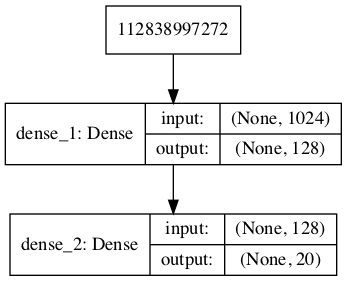

Instructions for updating:
Use tf.cast instead.
Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 19s 109us/step - loss: 1.4329 - acc: 0.6015 - val_loss: 1.1132 - val_acc: 0.6809
Epoch 2/100
178346/178346 [==============================] - 11s 61us/step - loss: 1.0324 - acc: 0.7047 - val_loss: 0.9756 - val_acc: 0.7252
Epoch 3/100
178346/178346 [==============================] - 11s 59us/step - loss: 0.9342 - acc: 0.7333 - val_loss: 0.9179 - val_acc: 0.7387
Epoch 4/100
178346/178346 [==============================] - 10s 59us/step - loss: 0.8851 - acc: 0.7485 - val_loss: 0.8875 - val_acc: 0.7417
Epoch 5/100
178346/178346 [==============================] - 10s 58us/step - loss: 0.8438 - acc: 0.7601 - val_loss: 0.8685 - val_acc: 0.7333
Epoch 6/100
178346/178346 [==============================] - 10s 57us/step - loss: 0.8144 - acc: 0.7692 - val_loss: 0.8278 - val_acc: 0.7706
Epoch 7/100
178346/178346 [===========================

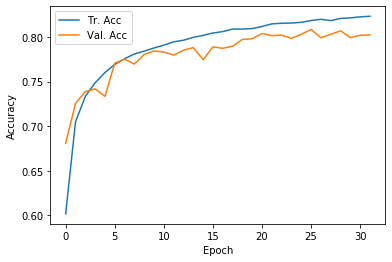

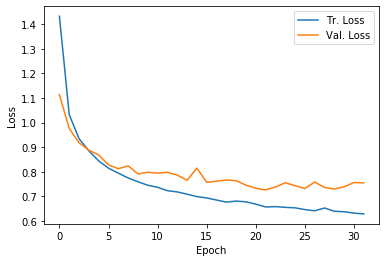

--- Test set evaluation ---
Loss              : 0.7395
Accuracy          : 0.7992
Balanced accuracy : 0.4816


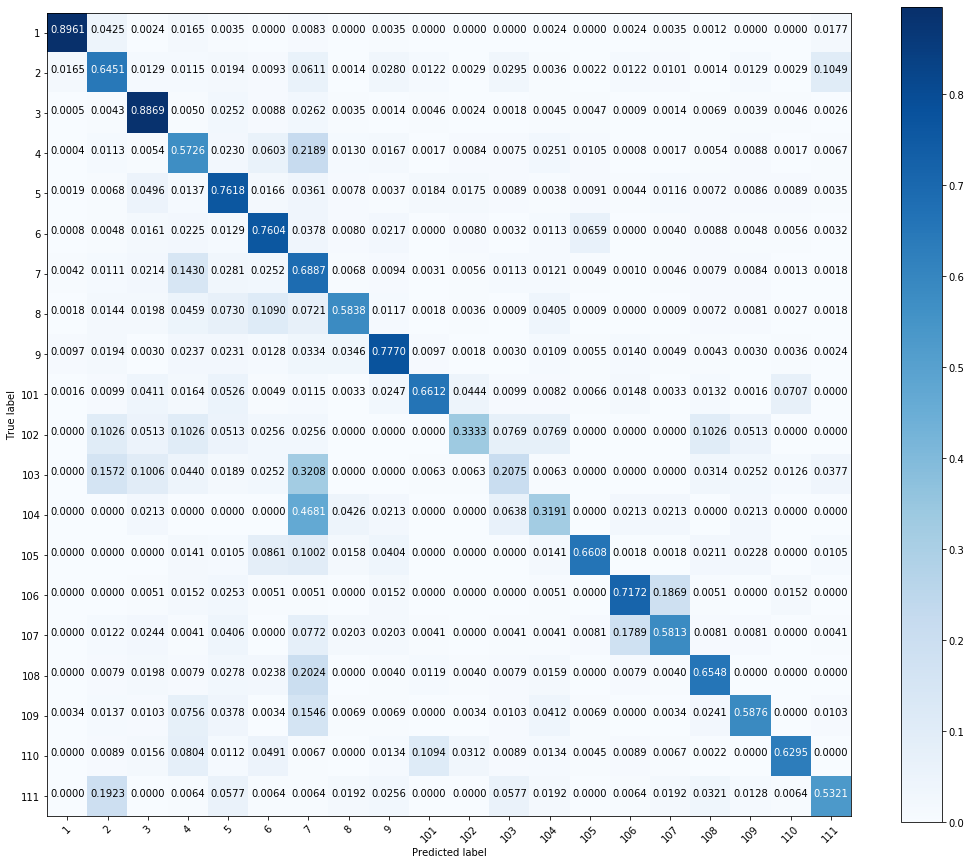

===== Model 1: num layers = 1, layer size = 128, activation = relu, learning rate = 0.001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2580      
Total params: 133,780
Trainable params: 133,780
Non-trainable params: 0
_________________________________________________________________
None


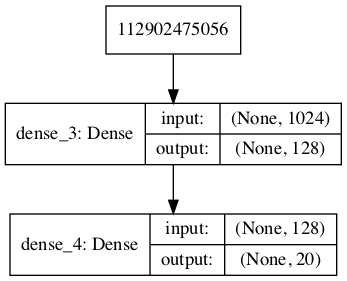

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 14s 78us/step - loss: 1.4774 - acc: 0.5844 - val_loss: 1.1947 - val_acc: 0.6562
Epoch 2/100
178346/178346 [==============================] - 11s 62us/step - loss: 1.0698 - acc: 0.6977 - val_loss: 0.9795 - val_acc: 0.7289
Epoch 3/100
178346/178346 [==============================] - 10s 55us/step - loss: 0.9067 - acc: 0.7491 - val_loss: 0.8550 - val_acc: 0.7646
Epoch 4/100
178346/178346 [==============================] - 10s 54us/step - loss: 0.8113 - acc: 0.7761 - val_loss: 0.8021 - val_acc: 0.7799
Epoch 5/100
178346/178346 [==============================] - 10s 54us/step - loss: 0.7465 - acc: 0.7942 - val_loss: 0.7362 - val_acc: 0.8007
Epoch 6/100
178346/178346 [==============================] - 9s 53us/step - loss: 0.7002 - acc: 0.8053 - val_loss: 0.6974 - val_acc: 0.8087
Epoch 7/100
178346/178346 [==============================] - 10s 55us/step - loss: 0.6625 - acc: 0.8156 

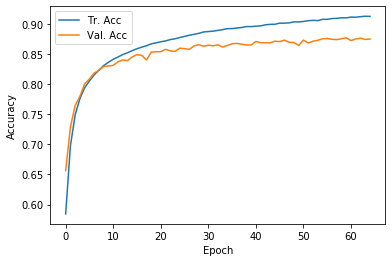

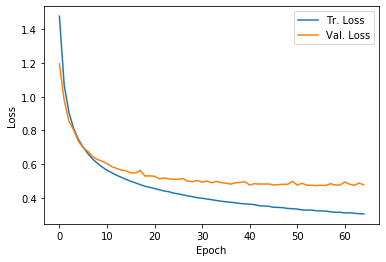

--- Test set evaluation ---
Loss              : 0.4836
Accuracy          : 0.8726
Balanced accuracy : 0.6556


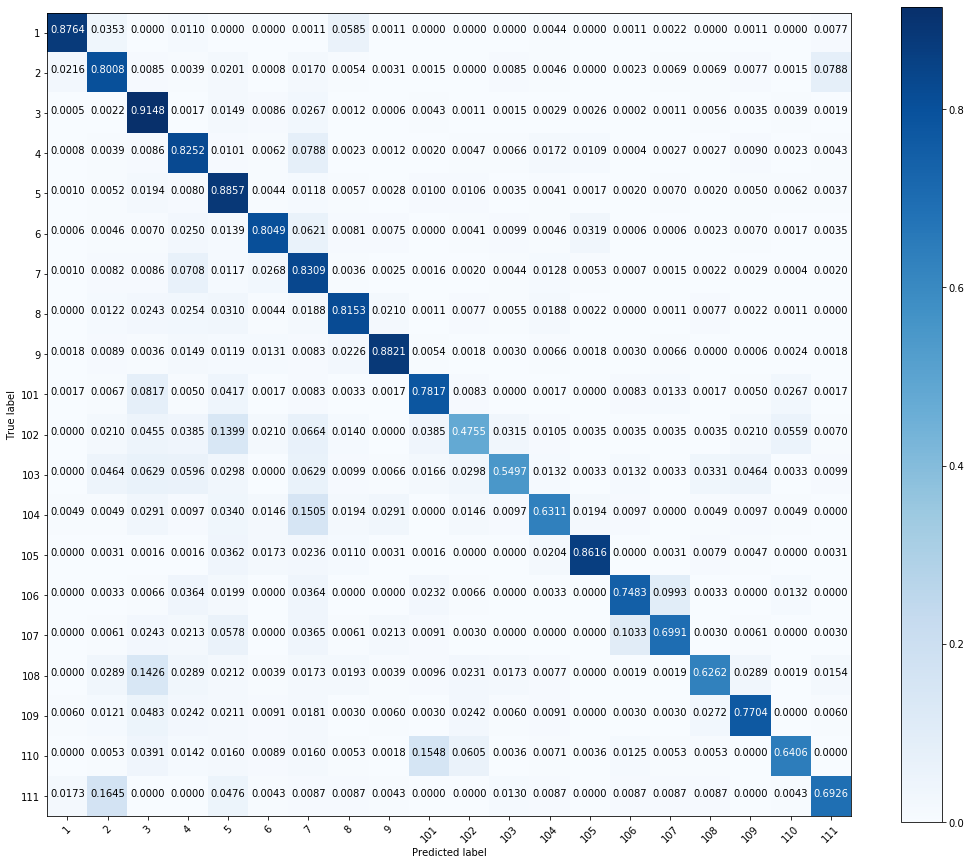

===== Model 2: num layers = 1, layer size = 128, activation = relu, learning rate = 0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_6 (Dense)              (None, 20)                2580      
Total params: 133,780
Trainable params: 133,780
Non-trainable params: 0
_________________________________________________________________
None


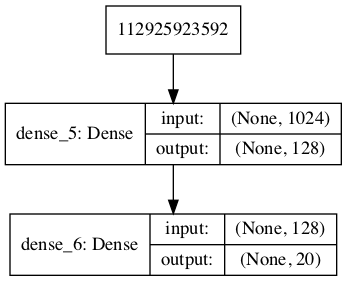

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 14s 77us/step - loss: 1.9613 - acc: 0.4895 - val_loss: 1.7527 - val_acc: 0.5370
Epoch 2/100
178346/178346 [==============================] - 10s 57us/step - loss: 1.6480 - acc: 0.5454 - val_loss: 1.5658 - val_acc: 0.5665
Epoch 3/100
178346/178346 [==============================] - 10s 56us/step - loss: 1.5001 - acc: 0.5762 - val_loss: 1.4473 - val_acc: 0.5971
Epoch 4/100
178346/178346 [==============================] - 10s 56us/step - loss: 1.4001 - acc: 0.6043 - val_loss: 1.3625 - val_acc: 0.6147
Epoch 5/100
178346/178346 [==============================] - 10s 56us/step - loss: 1.3250 - acc: 0.6237 - val_loss: 1.2958 - val_acc: 0.6335
Epoch 6/100
178346/178346 [==============================] - 10s 58us/step - loss: 1.2648 - acc: 0.6411 - val_loss: 1.2405 - val_acc: 0.6474
Epoch 7/100
178346/178346 [==============================] - 10s 56us/step - loss: 1.2139 - acc: 0.6543

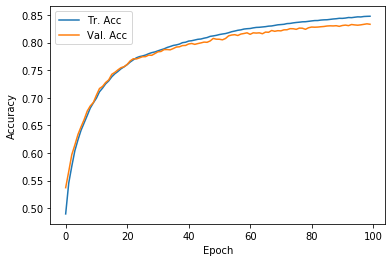

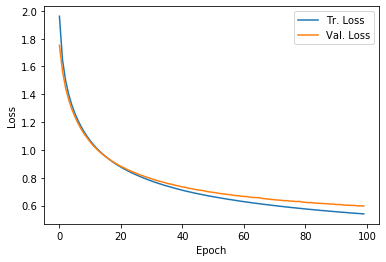

--- Test set evaluation ---
Loss              : 0.6066
Accuracy          : 0.8310
Balanced accuracy : 0.5289


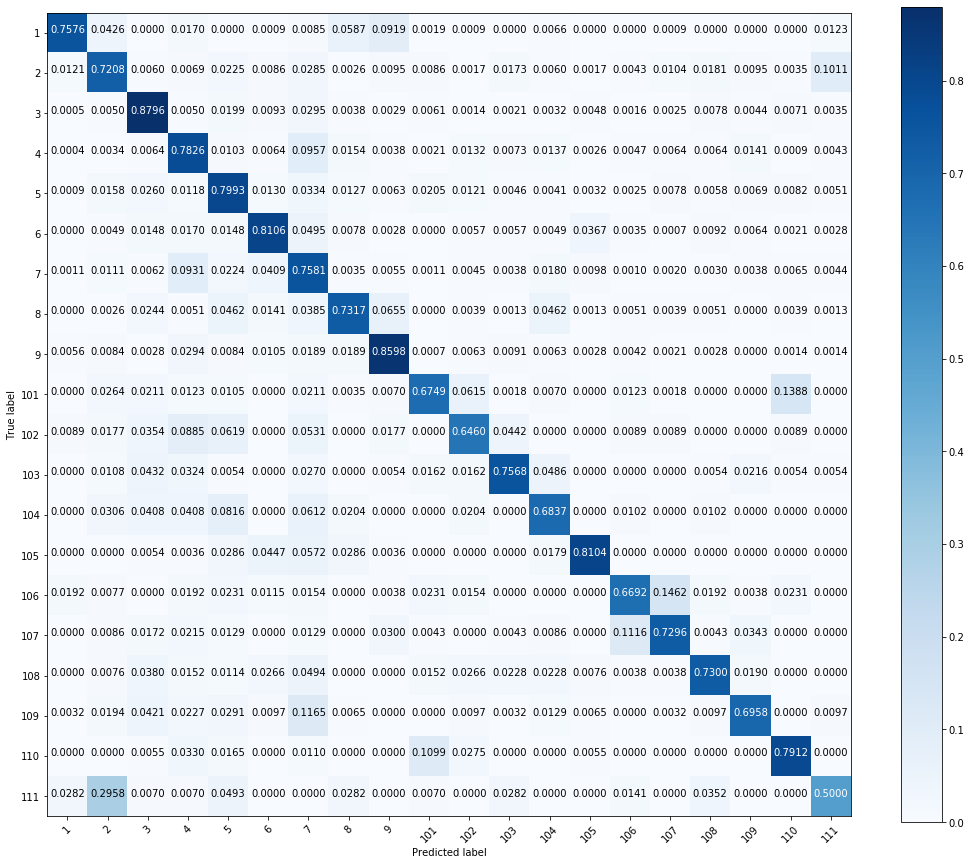

===== Model 3: num layers = 1, layer size = 256, activation = relu, learning rate = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_8 (Dense)              (None, 20)                5140      
Total params: 267,540
Trainable params: 267,540
Non-trainable params: 0
_________________________________________________________________
None


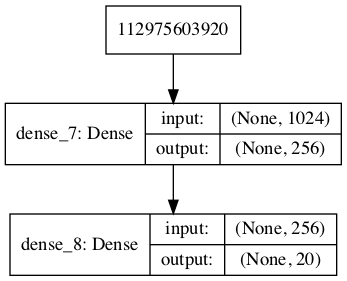

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 13s 72us/step - loss: 1.5125 - acc: 0.6285 - val_loss: 0.9379 - val_acc: 0.7280
Epoch 2/100
178346/178346 [==============================] - 13s 71us/step - loss: 0.8528 - acc: 0.7548 - val_loss: 0.7812 - val_acc: 0.7814
Epoch 3/100
178346/178346 [==============================] - 14s 81us/step - loss: 0.7563 - acc: 0.7854 - val_loss: 0.7450 - val_acc: 0.7965
Epoch 4/100
178346/178346 [==============================] - 12s 66us/step - loss: 0.6901 - acc: 0.8054 - val_loss: 0.6898 - val_acc: 0.8062
Epoch 5/100
178346/178346 [==============================] - 11s 64us/step - loss: 0.6515 - acc: 0.8170 - val_loss: 0.6696 - val_acc: 0.8171
Epoch 6/100
178346/178346 [==============================] - 12s 65us/step - loss: 0.6254 - acc: 0.8261 - val_loss: 0.6563 - val_acc: 0.8205
Epoch 7/100
178346/178346 [==============================] - 11s 63us/step - loss: 0.6020 - acc: 0.8324

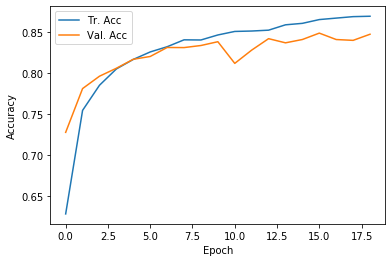

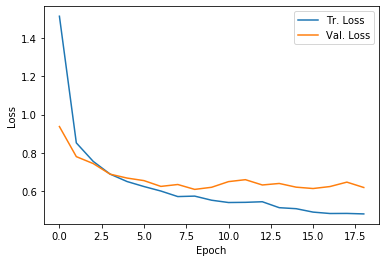

--- Test set evaluation ---
Loss              : 0.6157
Accuracy          : 0.8307
Balanced accuracy : 0.5937


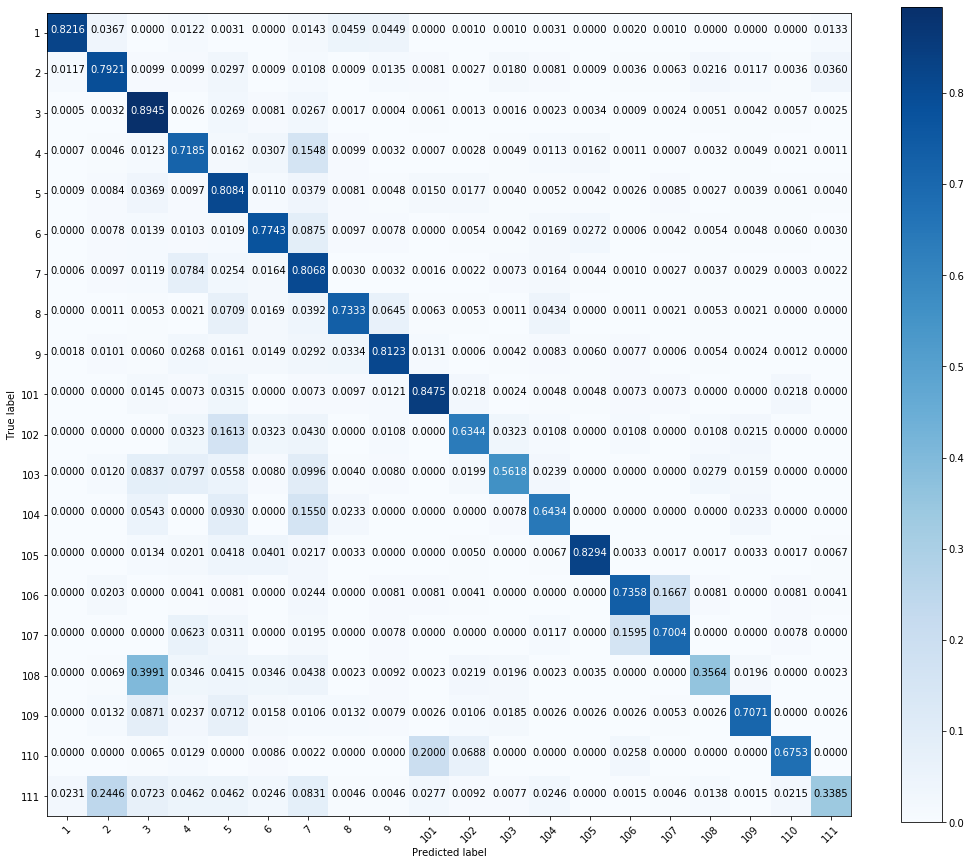

===== Model 4: num layers = 1, layer size = 256, activation = relu, learning rate = 0.001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_10 (Dense)             (None, 20)                5140      
Total params: 267,540
Trainable params: 267,540
Non-trainable params: 0
_________________________________________________________________
None


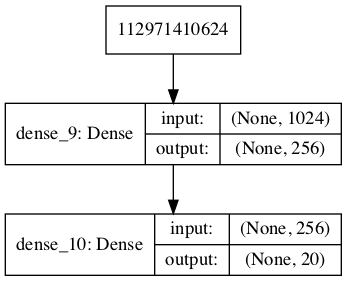

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 12s 69us/step - loss: 1.3772 - acc: 0.6057 - val_loss: 1.0692 - val_acc: 0.6977
Epoch 2/100
178346/178346 [==============================] - 11s 63us/step - loss: 0.9384 - acc: 0.7363 - val_loss: 0.8508 - val_acc: 0.7690
Epoch 3/100
178346/178346 [==============================] - 12s 65us/step - loss: 0.7764 - acc: 0.7851 - val_loss: 0.7345 - val_acc: 0.8013
Epoch 4/100
178346/178346 [==============================] - 11s 63us/step - loss: 0.6827 - acc: 0.8095 - val_loss: 0.6651 - val_acc: 0.8167
Epoch 5/100
178346/178346 [==============================] - 15s 83us/step - loss: 0.6172 - acc: 0.8260 - val_loss: 0.6142 - val_acc: 0.8312
Epoch 6/100
178346/178346 [==============================] - 12s 65us/step - loss: 0.5672 - acc: 0.8388 - val_loss: 0.5758 - val_acc: 0.8391
Epoch 7/100
178346/178346 [==============================] - 12s 69us/step - loss: 0.5270 - acc: 0.8496

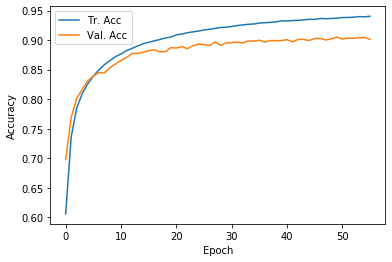

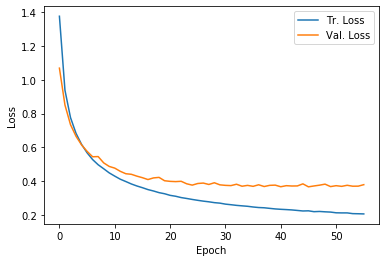

--- Test set evaluation ---
Loss              : 0.3724
Accuracy          : 0.9005
Balanced accuracy : 0.7193


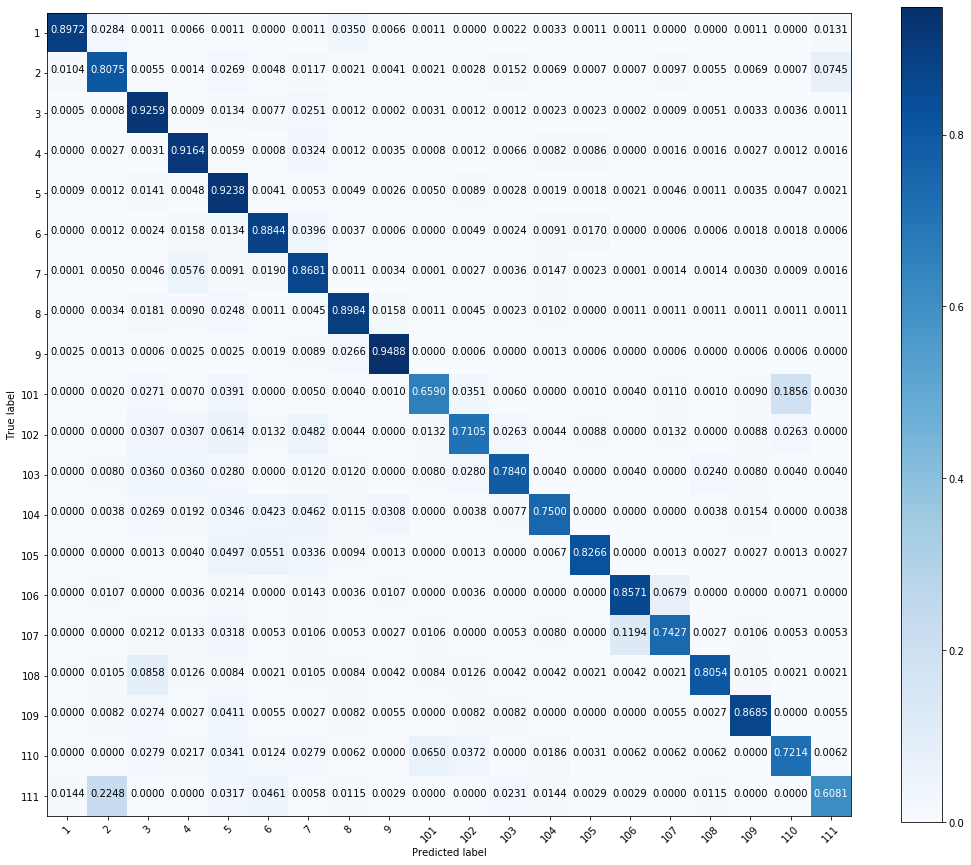

===== Model 5: num layers = 1, layer size = 256, activation = relu, learning rate = 0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_12 (Dense)             (None, 20)                5140      
Total params: 267,540
Trainable params: 267,540
Non-trainable params: 0
_________________________________________________________________
None


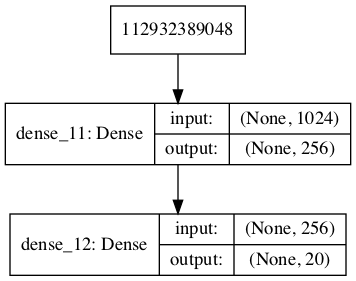

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 13s 75us/step - loss: 1.8143 - acc: 0.5151 - val_loss: 1.5984 - val_acc: 0.5512
Epoch 2/100
178346/178346 [==============================] - 12s 65us/step - loss: 1.4910 - acc: 0.5727 - val_loss: 1.4077 - val_acc: 0.6016
Epoch 3/100
178346/178346 [==============================] - 12s 67us/step - loss: 1.3460 - acc: 0.6200 - val_loss: 1.2969 - val_acc: 0.6369
Epoch 4/100
178346/178346 [==============================] - 12s 65us/step - loss: 1.2516 - acc: 0.6505 - val_loss: 1.2141 - val_acc: 0.6608
Epoch 5/100
178346/178346 [==============================] - 12s 68us/step - loss: 1.1782 - acc: 0.6700 - val_loss: 1.1505 - val_acc: 0.6819
Epoch 6/100
178346/178346 [==============================] - 11s 64us/step - loss: 1.1182 - acc: 0.6906 - val_loss: 1.0963 - val_acc: 0.6981
Epoch 7/100
178346/178346 [==============================] - 12s 69us/step - loss: 1.0671 - acc: 0.7031

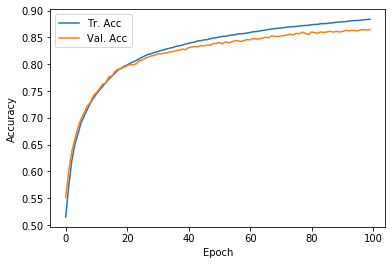

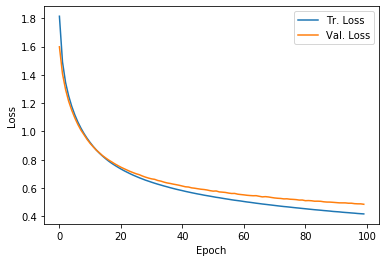

--- Test set evaluation ---
Loss              : 0.4977
Accuracy          : 0.8605
Balanced accuracy : 0.6076


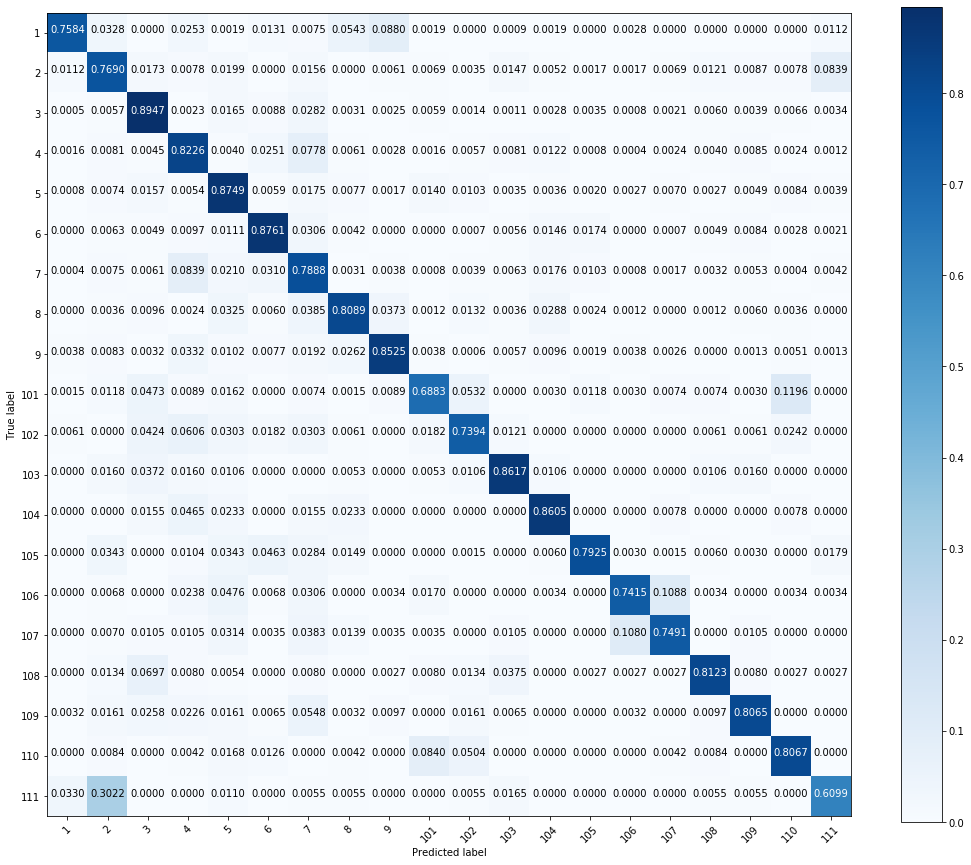

===== Model 6: num layers = 1, layer size = 512, activation = relu, learning rate = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_14 (Dense)             (None, 20)                10260     
Total params: 535,060
Trainable params: 535,060
Non-trainable params: 0
_________________________________________________________________
None


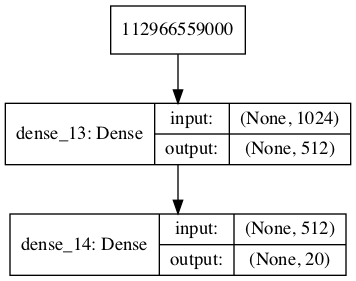

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 17s 97us/step - loss: 1.9119 - acc: 0.6256 - val_loss: 0.8941 - val_acc: 0.7424
Epoch 2/100
178346/178346 [==============================] - 16s 88us/step - loss: 0.8226 - acc: 0.7653 - val_loss: 0.7684 - val_acc: 0.7888
Epoch 3/100
178346/178346 [==============================] - 16s 92us/step - loss: 0.7216 - acc: 0.7956 - val_loss: 0.7150 - val_acc: 0.8045
Epoch 4/100
178346/178346 [==============================] - 16s 92us/step - loss: 0.6638 - acc: 0.8115 - val_loss: 0.6639 - val_acc: 0.8163
Epoch 5/100
178346/178346 [==============================] - 16s 90us/step - loss: 0.6286 - acc: 0.8245 - val_loss: 0.6713 - val_acc: 0.8209
Epoch 6/100
178346/178346 [==============================] - 18s 101us/step - loss: 0.6065 - acc: 0.8316 - val_loss: 0.6645 - val_acc: 0.8341
Epoch 7/100
178346/178346 [==============================] - 17s 93us/step - loss: 0.5874 - acc: 0.837

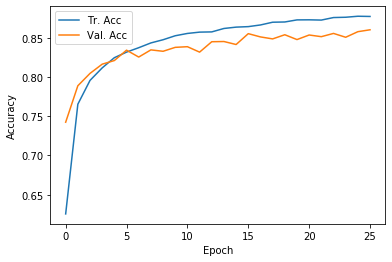

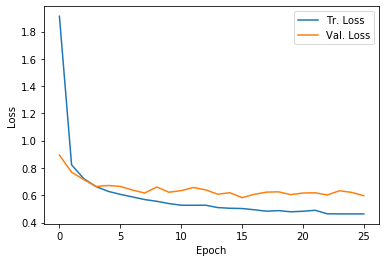

--- Test set evaluation ---
Loss              : 0.6039
Accuracy          : 0.8514
Balanced accuracy : 0.6212


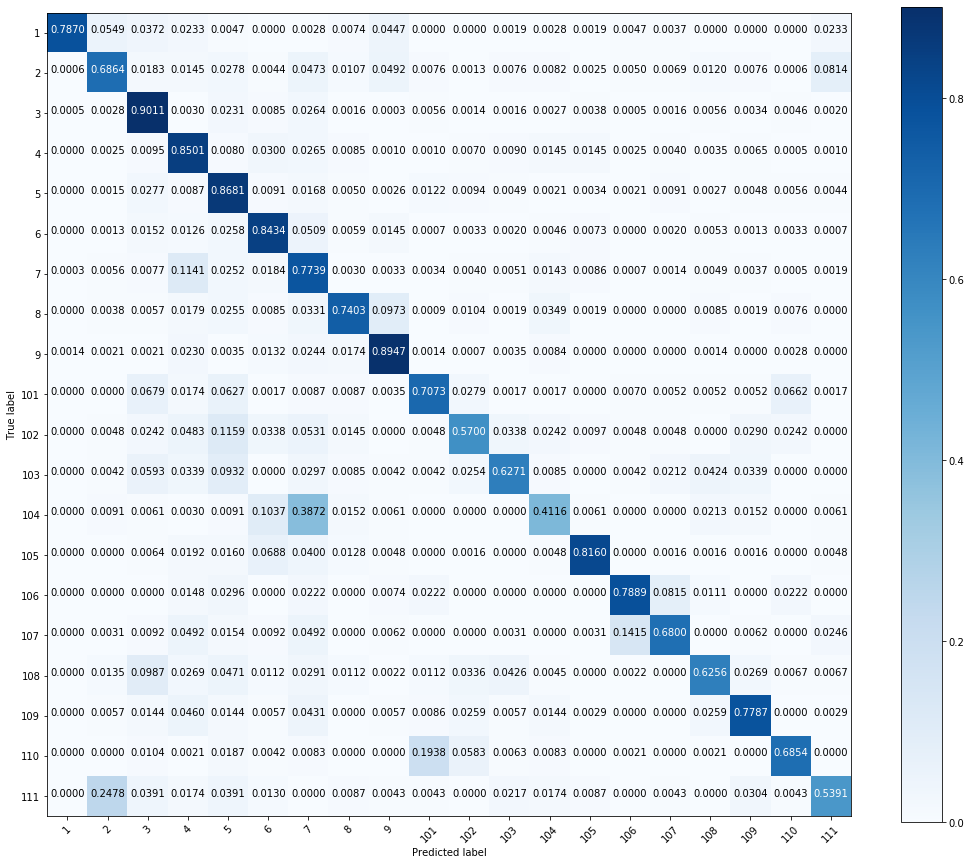

===== Model 7: num layers = 1, layer size = 512, activation = relu, learning rate = 0.001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_16 (Dense)             (None, 20)                10260     
Total params: 535,060
Trainable params: 535,060
Non-trainable params: 0
_________________________________________________________________
None


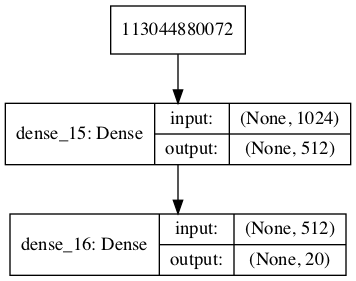

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 18s 98us/step - loss: 1.2581 - acc: 0.6433 - val_loss: 0.9382 - val_acc: 0.7357
Epoch 2/100
178346/178346 [==============================] - 17s 95us/step - loss: 0.8123 - acc: 0.7719 - val_loss: 0.7292 - val_acc: 0.7992
Epoch 3/100
178346/178346 [==============================] - 17s 93us/step - loss: 0.6619 - acc: 0.8136 - val_loss: 0.6358 - val_acc: 0.8229
Epoch 4/100
178346/178346 [==============================] - 16s 90us/step - loss: 0.5738 - acc: 0.8368 - val_loss: 0.5695 - val_acc: 0.8416
Epoch 5/100
178346/178346 [==============================] - 17s 93us/step - loss: 0.5153 - acc: 0.8521 - val_loss: 0.5110 - val_acc: 0.8555
Epoch 6/100
178346/178346 [==============================] - 16s 92us/step - loss: 0.4727 - acc: 0.8633 - val_loss: 0.4931 - val_acc: 0.8555
Epoch 7/100
178346/178346 [==============================] - 17s 97us/step - loss: 0.4384 - acc: 0.8728

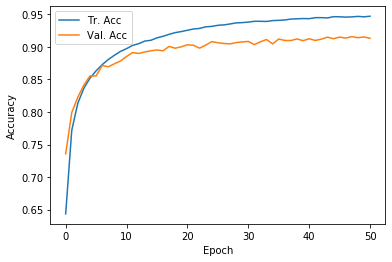

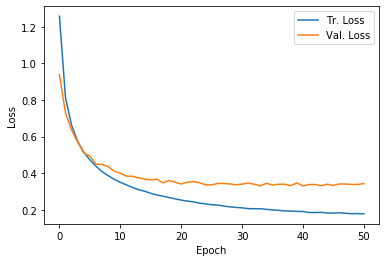

--- Test set evaluation ---
Loss              : 0.3433
Accuracy          : 0.9098
Balanced accuracy : 0.7488


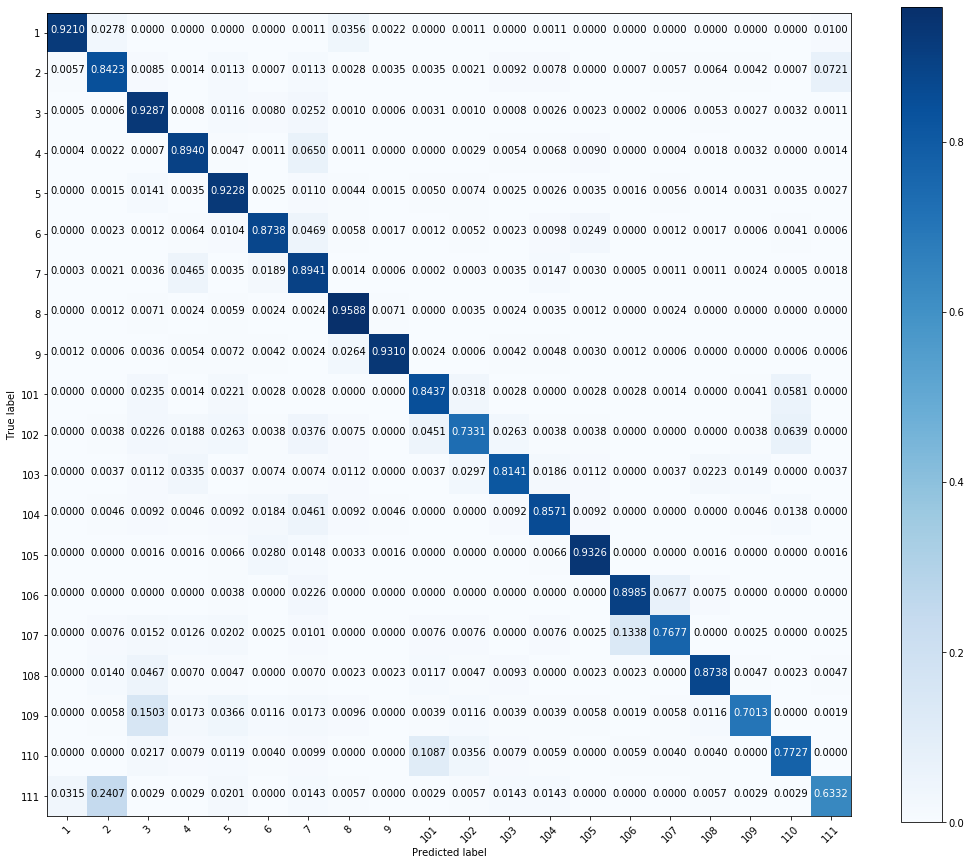

===== Model 8: num layers = 1, layer size = 512, activation = relu, learning rate = 0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_18 (Dense)             (None, 20)                10260     
Total params: 535,060
Trainable params: 535,060
Non-trainable params: 0
_________________________________________________________________
None


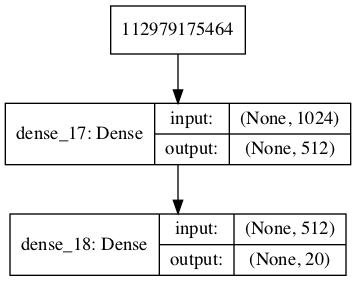

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 21s 116us/step - loss: 1.7631 - acc: 0.5130 - val_loss: 1.5105 - val_acc: 0.5696
Epoch 2/100
178346/178346 [==============================] - 17s 94us/step - loss: 1.4063 - acc: 0.5945 - val_loss: 1.3224 - val_acc: 0.6176
Epoch 3/100
178346/178346 [==============================] - 16s 90us/step - loss: 1.2597 - acc: 0.6409 - val_loss: 1.2061 - val_acc: 0.6574
Epoch 4/100
178346/178346 [==============================] - 16s 92us/step - loss: 1.1569 - acc: 0.6737 - val_loss: 1.1166 - val_acc: 0.6889
Epoch 5/100
178346/178346 [==============================] - 16s 91us/step - loss: 1.0750 - acc: 0.6985 - val_loss: 1.0432 - val_acc: 0.7091
Epoch 6/100
178346/178346 [==============================] - 16s 92us/step - loss: 1.0083 - acc: 0.7175 - val_loss: 0.9845 - val_acc: 0.7311
Epoch 7/100
178346/178346 [==============================] - 16s 92us/step - loss: 0.9526 - acc: 0.732

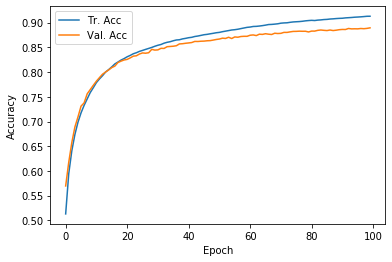

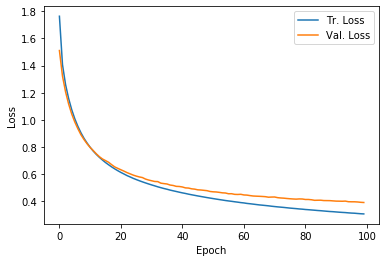

--- Test set evaluation ---
Loss              : 0.4023
Accuracy          : 0.8861
Balanced accuracy : 0.6747


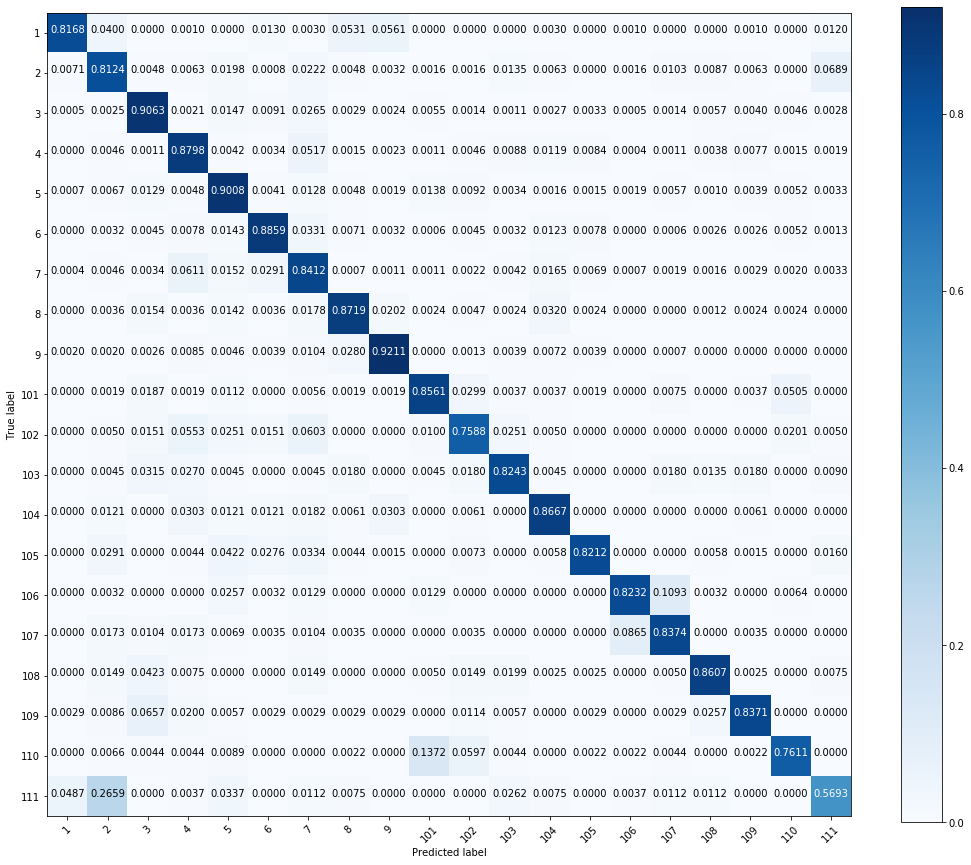

===== Model 9: num layers = 2, layer size = 128, activation = relu, learning rate = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 20)                2580      
Total params: 150,292
Trainable params: 150,292
Non-trainable params: 0
_________________________________________________________________
None


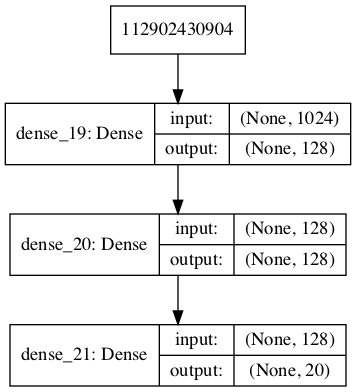

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 12s 67us/step - loss: 1.1775 - acc: 0.6589 - val_loss: 0.8608 - val_acc: 0.7482
Epoch 2/100
178346/178346 [==============================] - 11s 60us/step - loss: 0.7385 - acc: 0.7864 - val_loss: 0.7344 - val_acc: 0.7922
Epoch 3/100
178346/178346 [==============================] - 11s 60us/step - loss: 0.6332 - acc: 0.8183 - val_loss: 0.6230 - val_acc: 0.8270
Epoch 4/100
178346/178346 [==============================] - 10s 59us/step - loss: 0.5750 - acc: 0.8341 - val_loss: 0.5986 - val_acc: 0.8295
Epoch 5/100
178346/178346 [==============================] - 13s 74us/step - loss: 0.5379 - acc: 0.8442 - val_loss: 0.5545 - val_acc: 0.8481
Epoch 6/100
178346/178346 [==============================] - 11s 62us/step - loss: 0.5092 - acc: 0.8521 - val_loss: 0.5476 - val_acc: 0.8417
Epoch 7/100
178346/178346 [==============================] - 12s 68us/step - loss: 0.4930 - acc: 0.8572

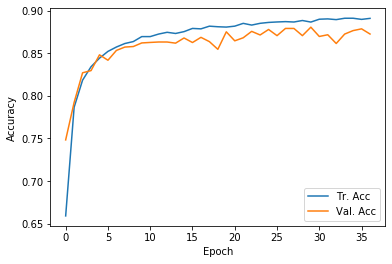

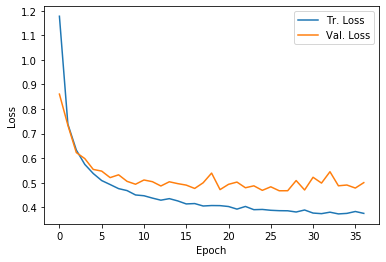

--- Test set evaluation ---
Loss              : 0.4727
Accuracy          : 0.8772
Balanced accuracy : 0.6542


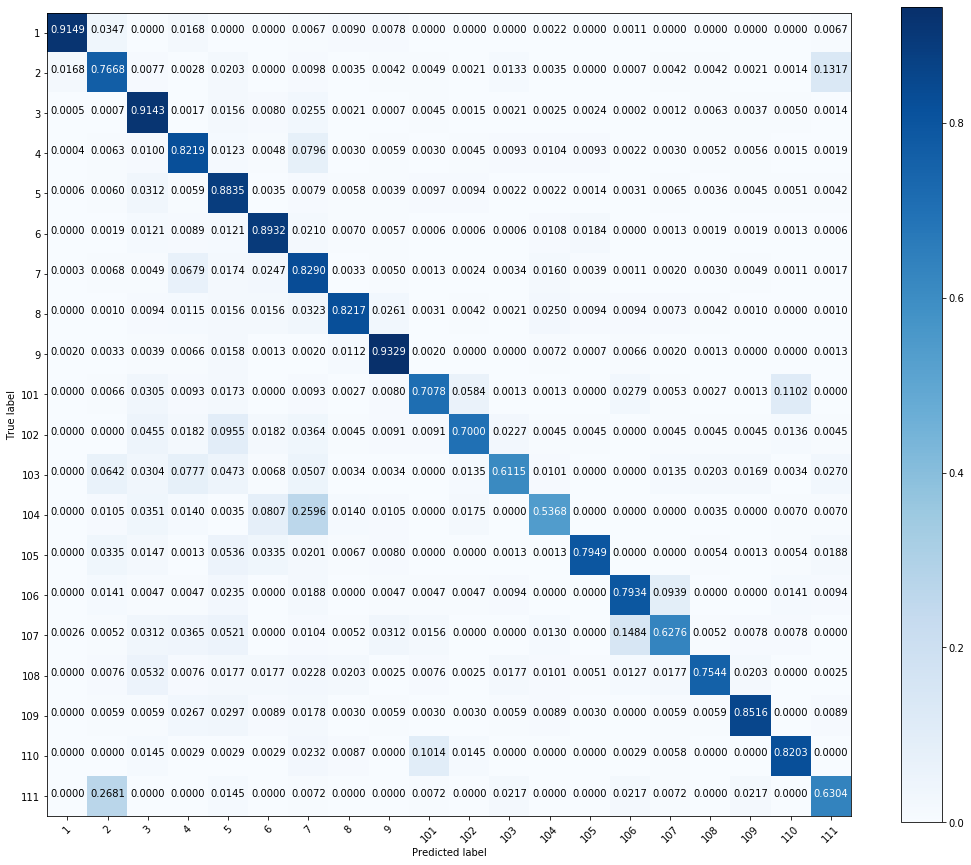

===== Model 10: num layers = 2, layer size = 128, activation = relu, learning rate = 0.001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_24 (Dense)             (None, 20)                2580      
Total params: 150,292
Trainable params: 150,292
Non-trainable params: 0
_________________________________________________________________
None


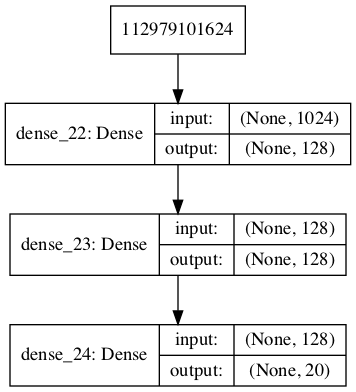

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 13s 74us/step - loss: 1.2784 - acc: 0.6369 - val_loss: 0.9231 - val_acc: 0.7390
Epoch 2/100
178346/178346 [==============================] - 15s 82us/step - loss: 0.7987 - acc: 0.7771 - val_loss: 0.7141 - val_acc: 0.8067
Epoch 3/100
178346/178346 [==============================] - 12s 66us/step - loss: 0.6487 - acc: 0.8178 - val_loss: 0.6102 - val_acc: 0.8288
Epoch 4/100
178346/178346 [==============================] - 12s 65us/step - loss: 0.5676 - acc: 0.8375 - val_loss: 0.5543 - val_acc: 0.8399
Epoch 5/100
178346/178346 [==============================] - 11s 64us/step - loss: 0.5134 - acc: 0.8506 - val_loss: 0.5108 - val_acc: 0.8525
Epoch 6/100
178346/178346 [==============================] - 11s 61us/step - loss: 0.4703 - acc: 0.8635 - val_loss: 0.4762 - val_acc: 0.8626
Epoch 7/100
178346/178346 [==============================] - 11s 61us/step - loss: 0.4374 - acc: 0.8723

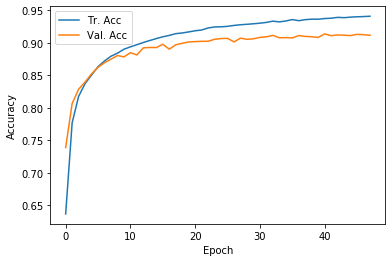

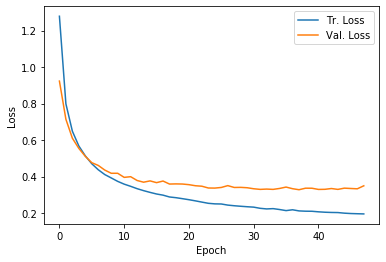

--- Test set evaluation ---
Loss              : 0.3369
Accuracy          : 0.9076
Balanced accuracy : 0.7412


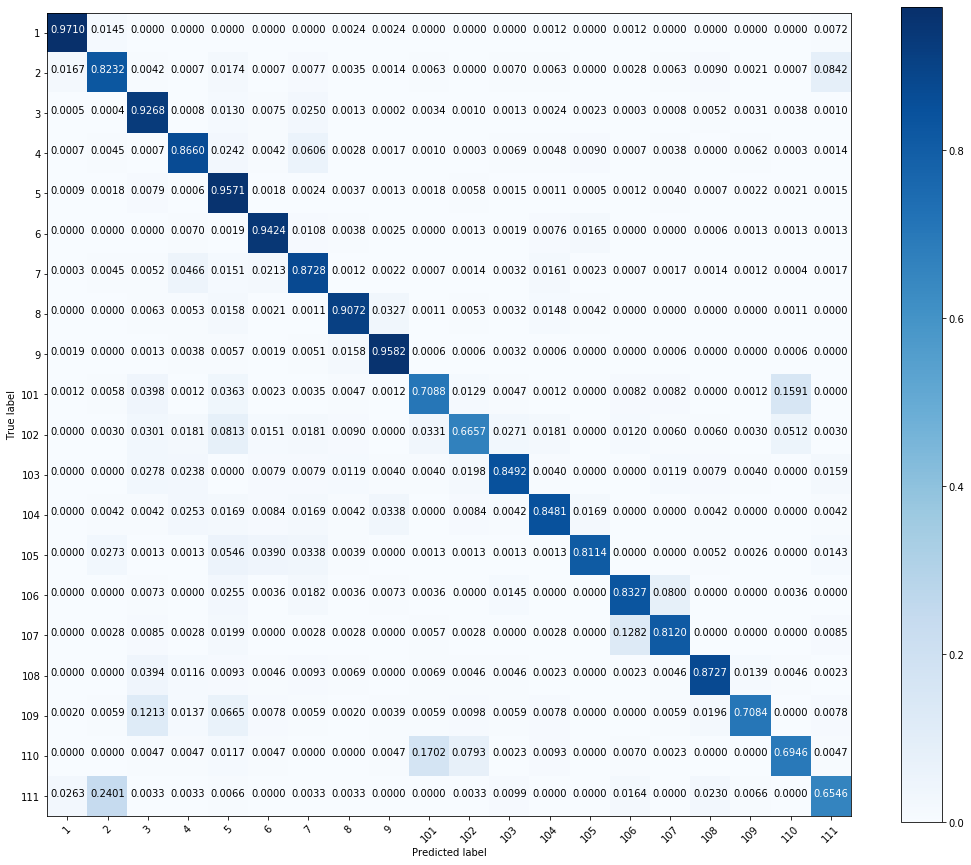

===== Model 11: num layers = 2, layer size = 128, activation = relu, learning rate = 0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 20)                2580      
Total params: 150,292
Trainable params: 150,292
Non-trainable params: 0
_________________________________________________________________
None


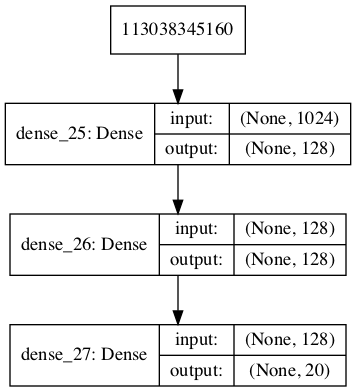

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 16s 90us/step - loss: 1.8372 - acc: 0.5031 - val_loss: 1.5827 - val_acc: 0.5352
Epoch 2/100
178346/178346 [==============================] - 11s 62us/step - loss: 1.4758 - acc: 0.5715 - val_loss: 1.3876 - val_acc: 0.6086
Epoch 3/100
178346/178346 [==============================] - 10s 59us/step - loss: 1.3115 - acc: 0.6273 - val_loss: 1.2488 - val_acc: 0.6465
Epoch 4/100
178346/178346 [==============================] - 11s 61us/step - loss: 1.1921 - acc: 0.6682 - val_loss: 1.1414 - val_acc: 0.6908
Epoch 5/100
178346/178346 [==============================] - 11s 61us/step - loss: 1.0991 - acc: 0.6986 - val_loss: 1.0610 - val_acc: 0.7097
Epoch 6/100
178346/178346 [==============================] - 11s 63us/step - loss: 1.0249 - acc: 0.7193 - val_loss: 0.9949 - val_acc: 0.7299
Epoch 7/100
178346/178346 [==============================] - 11s 63us/step - loss: 0.9653 - acc: 0.7332

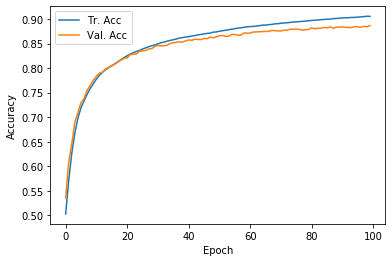

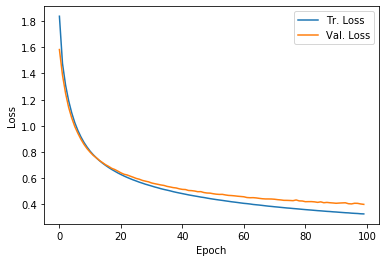

--- Test set evaluation ---
Loss              : 0.4115
Accuracy          : 0.8845
Balanced accuracy : 0.6660


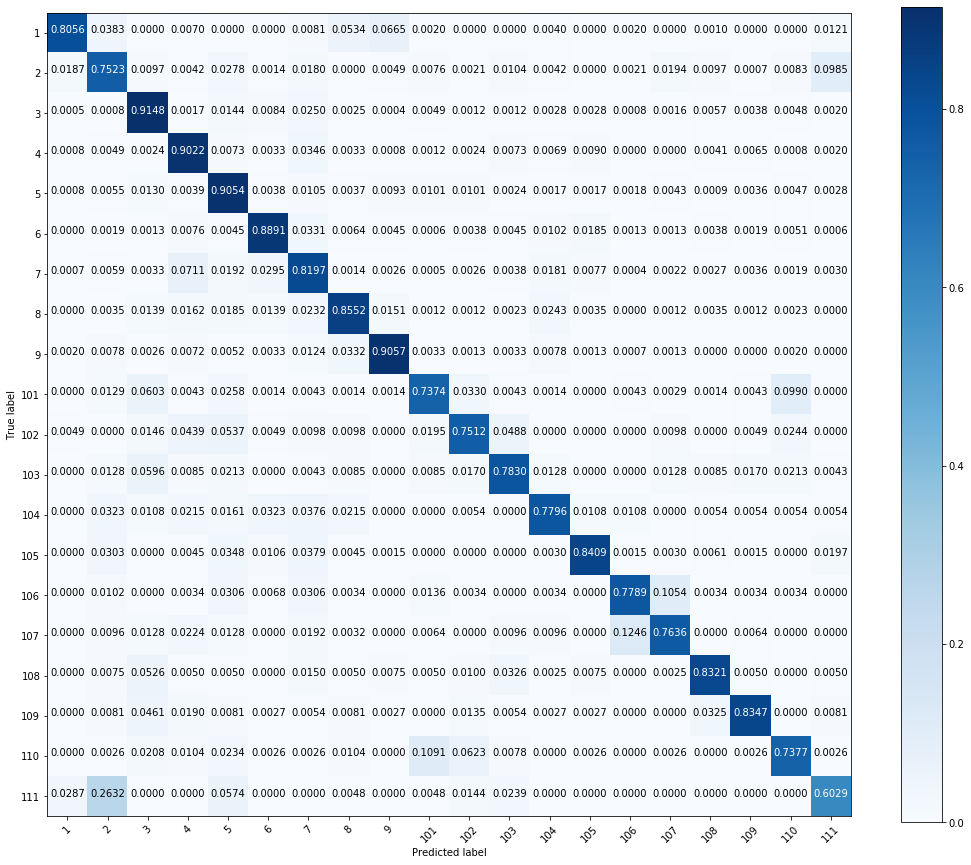

===== Model 12: num layers = 2, layer size = 256, activation = relu, learning rate = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_29 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_30 (Dense)             (None, 20)                5140      
Total params: 333,332
Trainable params: 333,332
Non-trainable params: 0
_________________________________________________________________
None


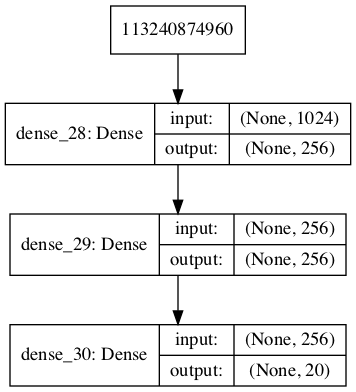

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 15s 83us/step - loss: 1.1209 - acc: 0.6886 - val_loss: 0.7344 - val_acc: 0.7886
Epoch 2/100
178346/178346 [==============================] - 14s 81us/step - loss: 0.6497 - acc: 0.8146 - val_loss: 0.6142 - val_acc: 0.8256
Epoch 3/100
178346/178346 [==============================] - 14s 77us/step - loss: 0.5533 - acc: 0.8416 - val_loss: 0.5275 - val_acc: 0.8491
Epoch 4/100
178346/178346 [==============================] - 17s 96us/step - loss: 0.5042 - acc: 0.8540 - val_loss: 0.5003 - val_acc: 0.8656
Epoch 5/100
178346/178346 [==============================] - 13s 74us/step - loss: 0.4702 - acc: 0.8640 - val_loss: 0.4693 - val_acc: 0.8711
Epoch 6/100
178346/178346 [==============================] - 14s 78us/step - loss: 0.4431 - acc: 0.8717 - val_loss: 0.4637 - val_acc: 0.8644
Epoch 7/100
178346/178346 [==============================] - 13s 74us/step - loss: 0.4297 - acc: 0.8746

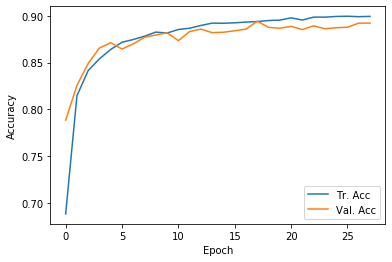

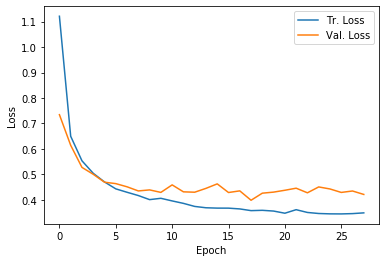

--- Test set evaluation ---
Loss              : 0.4094
Accuracy          : 0.8890
Balanced accuracy : 0.6981


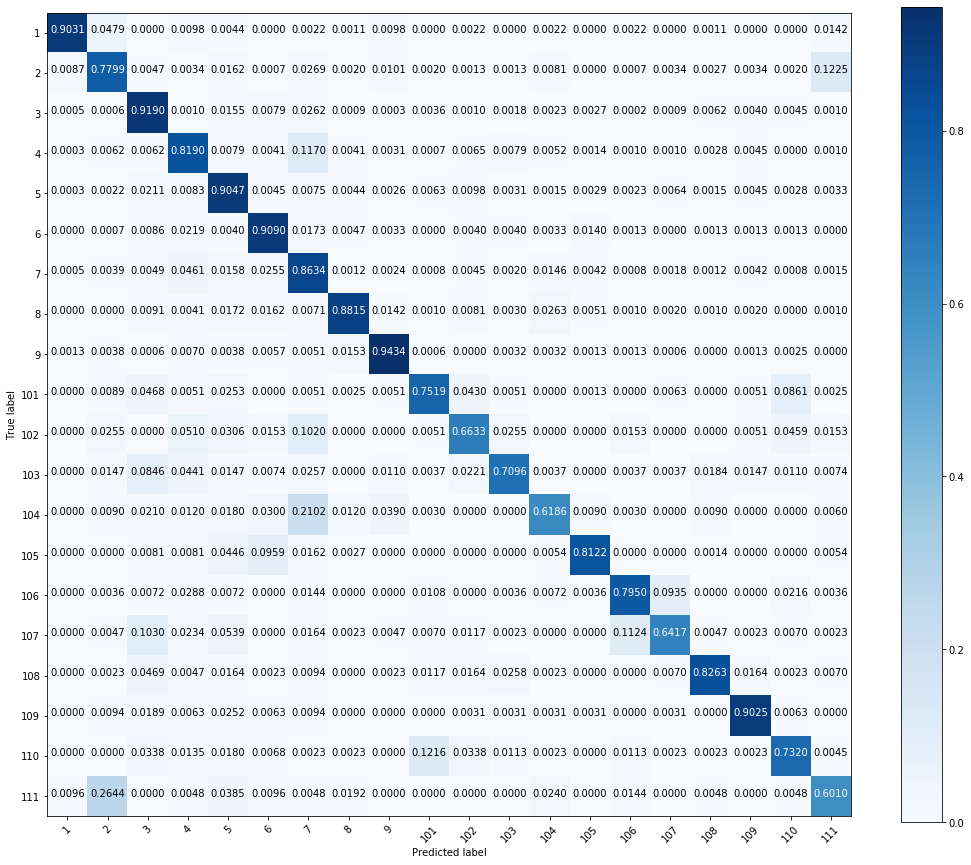

===== Model 13: num layers = 2, layer size = 256, activation = relu, learning rate = 0.001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_32 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_33 (Dense)             (None, 20)                5140      
Total params: 333,332
Trainable params: 333,332
Non-trainable params: 0
_________________________________________________________________
None


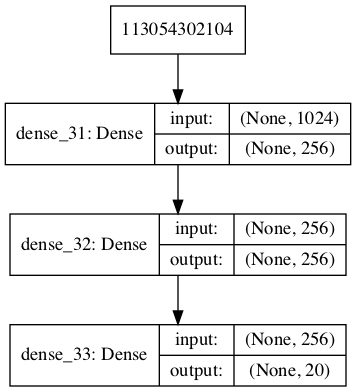

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 19s 104us/step - loss: 1.1508 - acc: 0.6701 - val_loss: 0.7918 - val_acc: 0.7725
Epoch 2/100
178346/178346 [==============================] - 13s 75us/step - loss: 0.6715 - acc: 0.8088 - val_loss: 0.5995 - val_acc: 0.8262
Epoch 3/100
178346/178346 [==============================] - 16s 91us/step - loss: 0.5375 - acc: 0.8446 - val_loss: 0.5127 - val_acc: 0.8518
Epoch 4/100
178346/178346 [==============================] - 14s 76us/step - loss: 0.4630 - acc: 0.8655 - val_loss: 0.4539 - val_acc: 0.8710
Epoch 5/100
178346/178346 [==============================] - 14s 76us/step - loss: 0.4155 - acc: 0.8782 - val_loss: 0.4345 - val_acc: 0.8768
Epoch 6/100
178346/178346 [==============================] - 13s 74us/step - loss: 0.3818 - acc: 0.8871 - val_loss: 0.3976 - val_acc: 0.8884
Epoch 7/100
178346/178346 [==============================] - 15s 82us/step - loss: 0.3528 - acc: 0.895

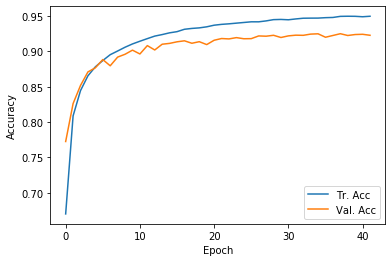

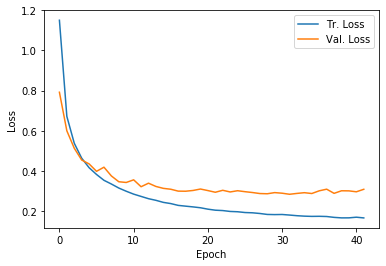

--- Test set evaluation ---
Loss              : 0.2968
Accuracy          : 0.9194
Balanced accuracy : 0.7888


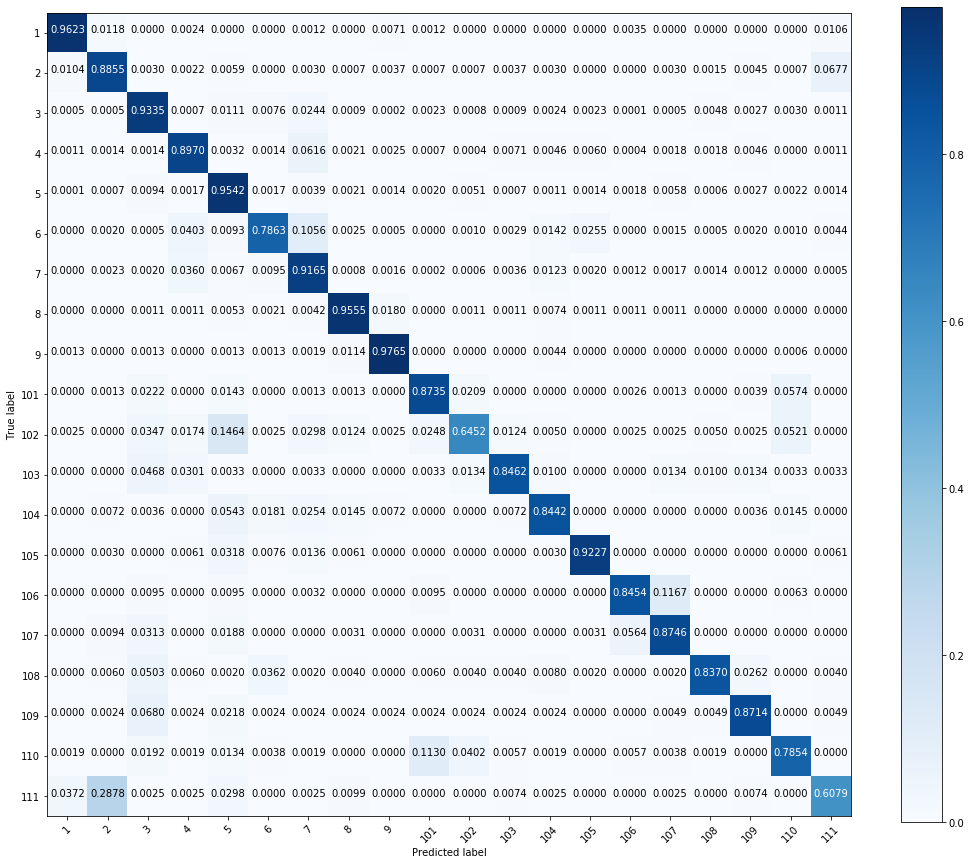

===== Model 14: num layers = 2, layer size = 256, activation = relu, learning rate = 0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_35 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_36 (Dense)             (None, 20)                5140      
Total params: 333,332
Trainable params: 333,332
Non-trainable params: 0
_________________________________________________________________
None


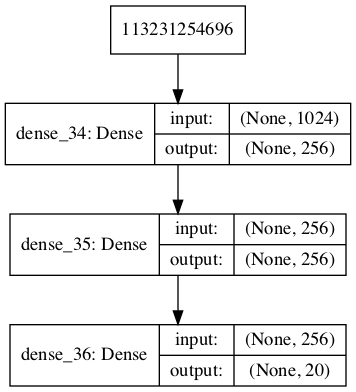

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 15s 84us/step - loss: 1.6759 - acc: 0.5302 - val_loss: 1.4130 - val_acc: 0.5985
Epoch 2/100
178346/178346 [==============================] - 13s 74us/step - loss: 1.2917 - acc: 0.6294 - val_loss: 1.1870 - val_acc: 0.6657
Epoch 3/100
178346/178346 [==============================] - 14s 77us/step - loss: 1.1110 - acc: 0.6926 - val_loss: 1.0434 - val_acc: 0.7152
Epoch 4/100
178346/178346 [==============================] - 13s 74us/step - loss: 0.9868 - acc: 0.7293 - val_loss: 0.9428 - val_acc: 0.7436
Epoch 5/100
178346/178346 [==============================] - 15s 82us/step - loss: 0.8975 - acc: 0.7521 - val_loss: 0.8661 - val_acc: 0.7637
Epoch 6/100
178346/178346 [==============================] - 15s 83us/step - loss: 0.8302 - acc: 0.7705 - val_loss: 0.8063 - val_acc: 0.7805
Epoch 7/100
178346/178346 [==============================] - 14s 80us/step - loss: 0.7758 - acc: 0.7881

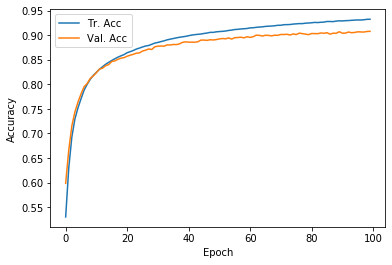

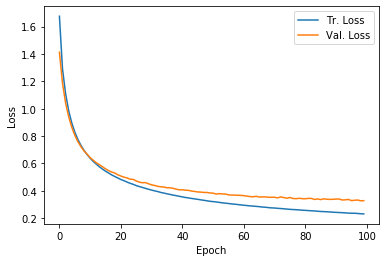

--- Test set evaluation ---
Loss              : 0.3365
Accuracy          : 0.9052
Balanced accuracy : 0.7324


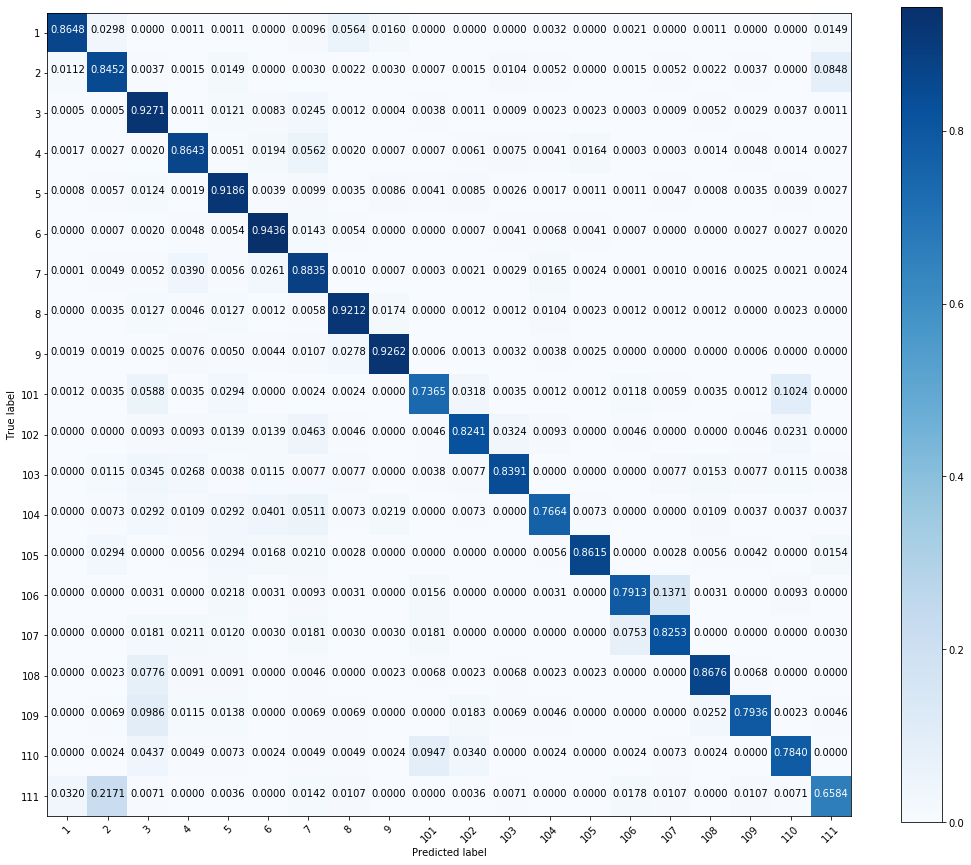

===== Model 15: num layers = 2, layer size = 512, activation = relu, learning rate = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_38 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_39 (Dense)             (None, 20)                10260     
Total params: 797,716
Trainable params: 797,716
Non-trainable params: 0
_________________________________________________________________
None


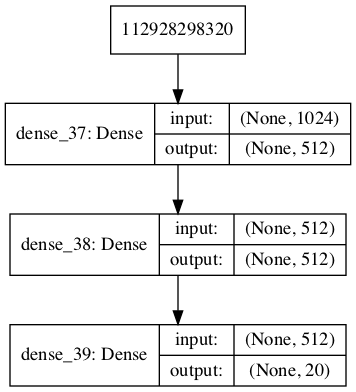

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 28s 158us/step - loss: 4.5660 - acc: 0.5372 - val_loss: 1.1124 - val_acc: 0.6876
Epoch 2/100
178346/178346 [==============================] - 26s 146us/step - loss: 0.9354 - acc: 0.7353 - val_loss: 0.8239 - val_acc: 0.7672
Epoch 3/100
178346/178346 [==============================] - 26s 148us/step - loss: 0.7690 - acc: 0.7805 - val_loss: 0.7414 - val_acc: 0.7900
Epoch 4/100
178346/178346 [==============================] - 24s 136us/step - loss: 0.7010 - acc: 0.8001 - val_loss: 0.6894 - val_acc: 0.8050
Epoch 5/100
178346/178346 [==============================] - 23s 131us/step - loss: 0.6550 - acc: 0.8127 - val_loss: 0.6466 - val_acc: 0.8171
Epoch 6/100
178346/178346 [==============================] - 24s 133us/step - loss: 0.6242 - acc: 0.8215 - val_loss: 0.6672 - val_acc: 0.8131
Epoch 7/100
178346/178346 [==============================] - 24s 132us/step - loss: 0.5974 - acc:

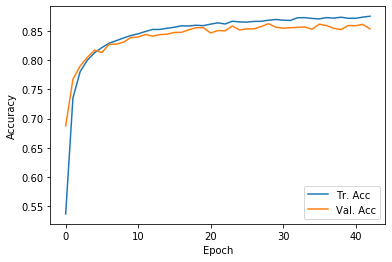

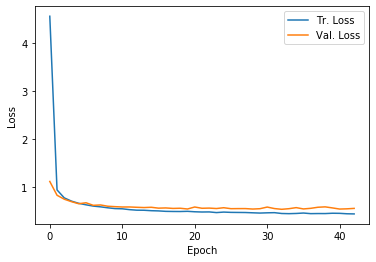

--- Test set evaluation ---
Loss              : 0.5416
Accuracy          : 0.8526
Balanced accuracy : 0.6193


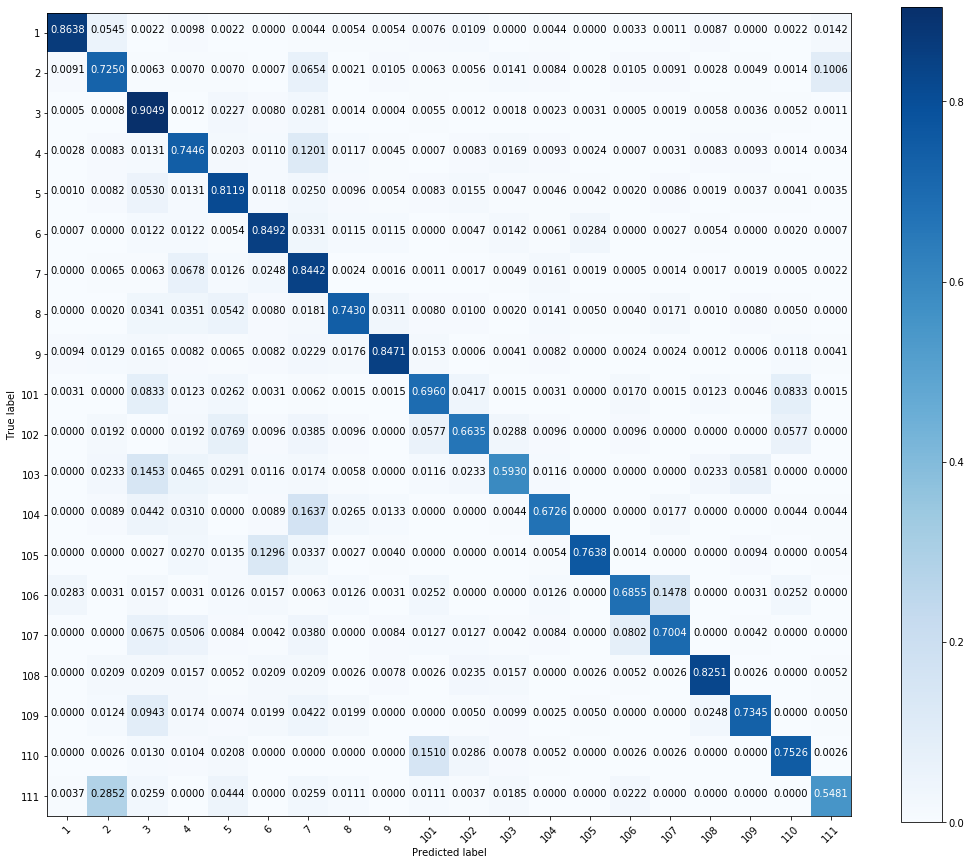

===== Model 16: num layers = 2, layer size = 512, activation = relu, learning rate = 0.001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_41 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_42 (Dense)             (None, 20)                10260     
Total params: 797,716
Trainable params: 797,716
Non-trainable params: 0
_________________________________________________________________
None


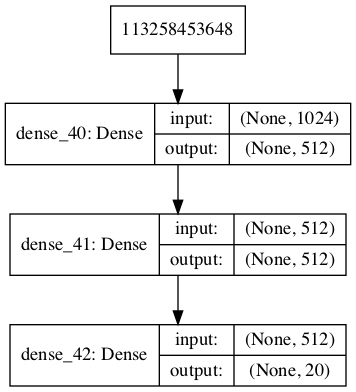

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 27s 151us/step - loss: 1.0283 - acc: 0.7057 - val_loss: 0.6940 - val_acc: 0.8050
Epoch 2/100
178346/178346 [==============================] - 25s 141us/step - loss: 0.5851 - acc: 0.8309 - val_loss: 0.5289 - val_acc: 0.8483
Epoch 3/100
178346/178346 [==============================] - 22s 125us/step - loss: 0.4661 - acc: 0.8638 - val_loss: 0.4493 - val_acc: 0.8707
Epoch 4/100
178346/178346 [==============================] - 23s 130us/step - loss: 0.4001 - acc: 0.8824 - val_loss: 0.3949 - val_acc: 0.8823
Epoch 5/100
178346/178346 [==============================] - 23s 128us/step - loss: 0.3568 - acc: 0.8941 - val_loss: 0.3756 - val_acc: 0.8867
Epoch 6/100
178346/178346 [==============================] - 23s 128us/step - loss: 0.3261 - acc: 0.9019 - val_loss: 0.3567 - val_acc: 0.8959
Epoch 7/100
178346/178346 [==============================] - 22s 125us/step - loss: 0.3009 - acc:

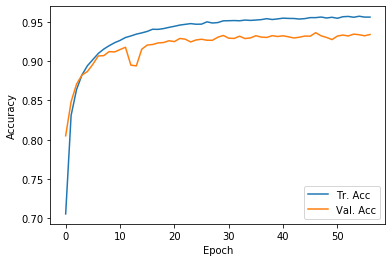

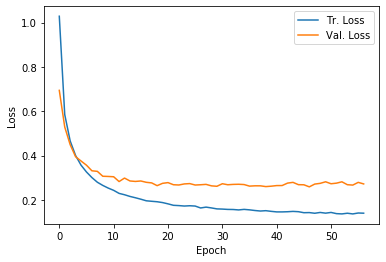

--- Test set evaluation ---
Loss              : 0.2707
Accuracy          : 0.9347
Balanced accuracy : 0.8214


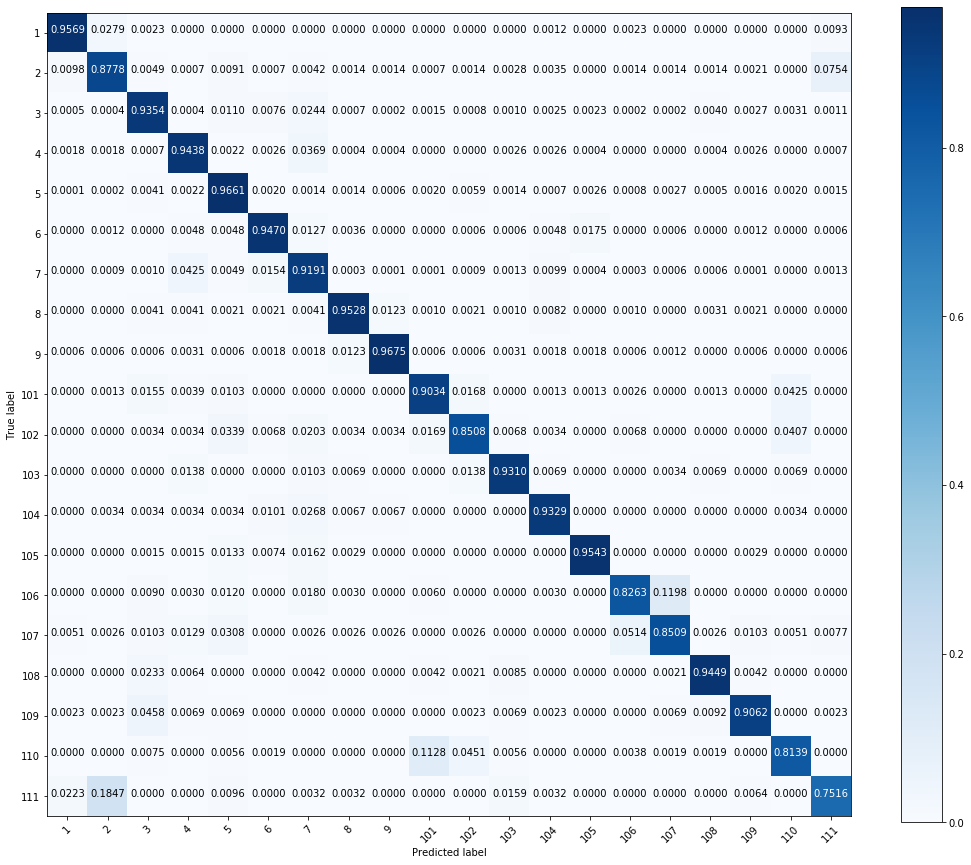

===== Model 17: num layers = 2, layer size = 512, activation = relu, learning rate = 0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_44 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_45 (Dense)             (None, 20)                10260     
Total params: 797,716
Trainable params: 797,716
Non-trainable params: 0
_________________________________________________________________
None


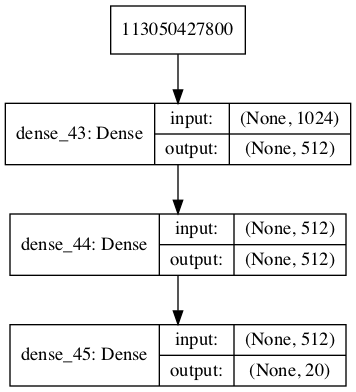

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 28s 156us/step - loss: 1.5030 - acc: 0.5652 - val_loss: 1.2321 - val_acc: 0.6433
Epoch 2/100
178346/178346 [==============================] - 22s 125us/step - loss: 1.0915 - acc: 0.6971 - val_loss: 0.9825 - val_acc: 0.7288
Epoch 3/100
178346/178346 [==============================] - 23s 126us/step - loss: 0.9000 - acc: 0.7524 - val_loss: 0.8461 - val_acc: 0.7768
Epoch 4/100
178346/178346 [==============================] - 22s 125us/step - loss: 0.7894 - acc: 0.7825 - val_loss: 0.7536 - val_acc: 0.7931
Epoch 5/100
178346/178346 [==============================] - 22s 124us/step - loss: 0.7146 - acc: 0.8013 - val_loss: 0.6955 - val_acc: 0.8062
Epoch 6/100
178346/178346 [==============================] - 24s 133us/step - loss: 0.6609 - acc: 0.8151 - val_loss: 0.6488 - val_acc: 0.8201
Epoch 7/100
178346/178346 [==============================] - 23s 127us/step - loss: 0.6184 - acc:

Epoch 58/100
178346/178346 [==============================] - 25s 140us/step - loss: 0.2321 - acc: 0.9325 - val_loss: 0.3314 - val_acc: 0.9021
Epoch 59/100
178346/178346 [==============================] - 23s 129us/step - loss: 0.2314 - acc: 0.9327 - val_loss: 0.3228 - val_acc: 0.9078
Epoch 60/100
178346/178346 [==============================] - 23s 131us/step - loss: 0.2288 - acc: 0.9334 - val_loss: 0.3183 - val_acc: 0.9086
Epoch 61/100
178346/178346 [==============================] - 24s 135us/step - loss: 0.2275 - acc: 0.9338 - val_loss: 0.3220 - val_acc: 0.9098
Epoch 62/100
178346/178346 [==============================] - 24s 134us/step - loss: 0.2246 - acc: 0.9349 - val_loss: 0.3170 - val_acc: 0.9105
Epoch 63/100
178346/178346 [==============================] - 24s 136us/step - loss: 0.2240 - acc: 0.9350 - val_loss: 0.3193 - val_acc: 0.9101
Epoch 64/100
178346/178346 [==============================] - 22s 122us/step - loss: 0.2221 - acc: 0.9352 - val_loss: 0.3243 - val_acc: 0.9085

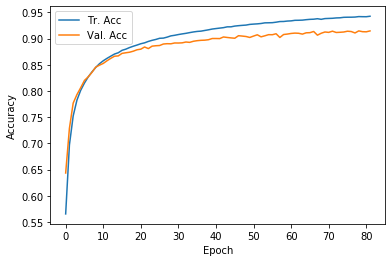

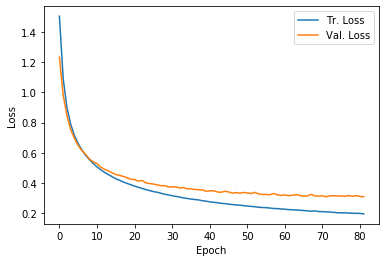

--- Test set evaluation ---
Loss              : 0.3212
Accuracy          : 0.9110
Balanced accuracy : 0.7515


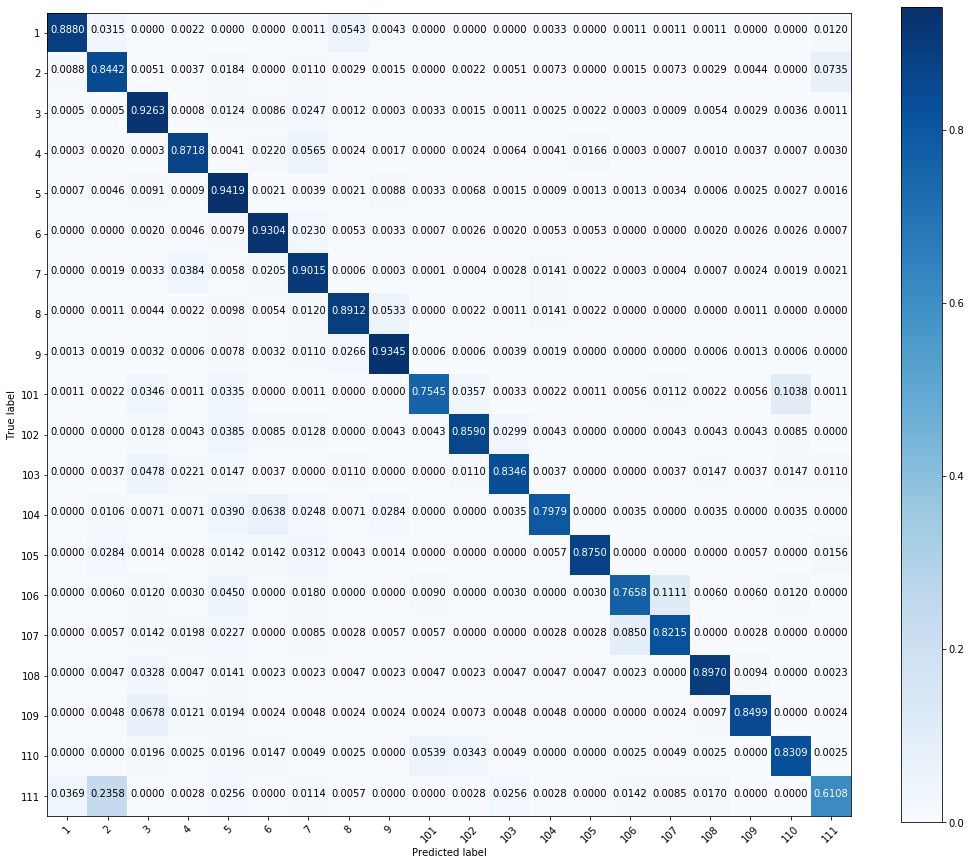

===== Model 18: num layers = 3, layer size = 128, activation = relu, learning rate = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_47 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_48 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_49 (Dense)             (None, 20)                2580      
Total params: 166,804
Trainable params: 166,804
Non-trainable params: 0
_________________________________________________________________
None


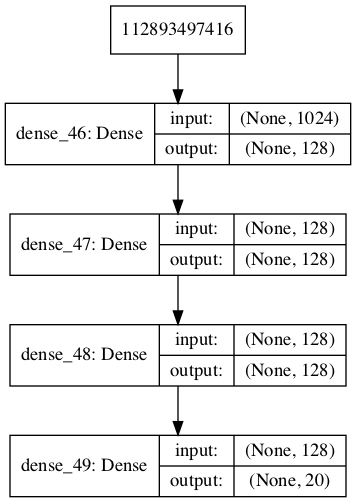

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 14s 80us/step - loss: 1.0576 - acc: 0.6949 - val_loss: 0.7224 - val_acc: 0.7903
Epoch 2/100
178346/178346 [==============================] - 16s 90us/step - loss: 0.6385 - acc: 0.8138 - val_loss: 0.5980 - val_acc: 0.8307
Epoch 3/100
178346/178346 [==============================] - 15s 86us/step - loss: 0.5511 - acc: 0.8390 - val_loss: 0.5340 - val_acc: 0.8364
Epoch 4/100
178346/178346 [==============================] - 13s 73us/step - loss: 0.5037 - acc: 0.8517 - val_loss: 0.5018 - val_acc: 0.8517
Epoch 5/100
178346/178346 [==============================] - 14s 76us/step - loss: 0.4736 - acc: 0.8597 - val_loss: 0.5649 - val_acc: 0.8253
Epoch 6/100
178346/178346 [==============================] - 13s 72us/step - loss: 0.4752 - acc: 0.8625 - val_loss: 0.4758 - val_acc: 0.8630
Epoch 7/100
178346/178346 [==============================] - 13s 72us/step - loss: 0.4352 - acc: 0.8706

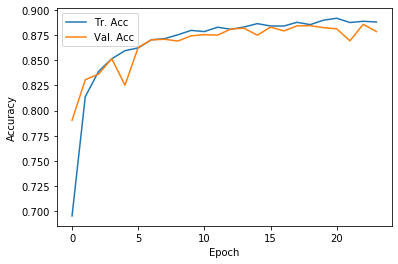

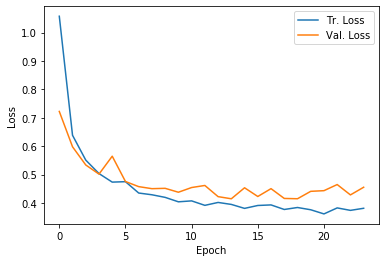

--- Test set evaluation ---
Loss              : 0.4220
Accuracy          : 0.8823
Balanced accuracy : 0.6682


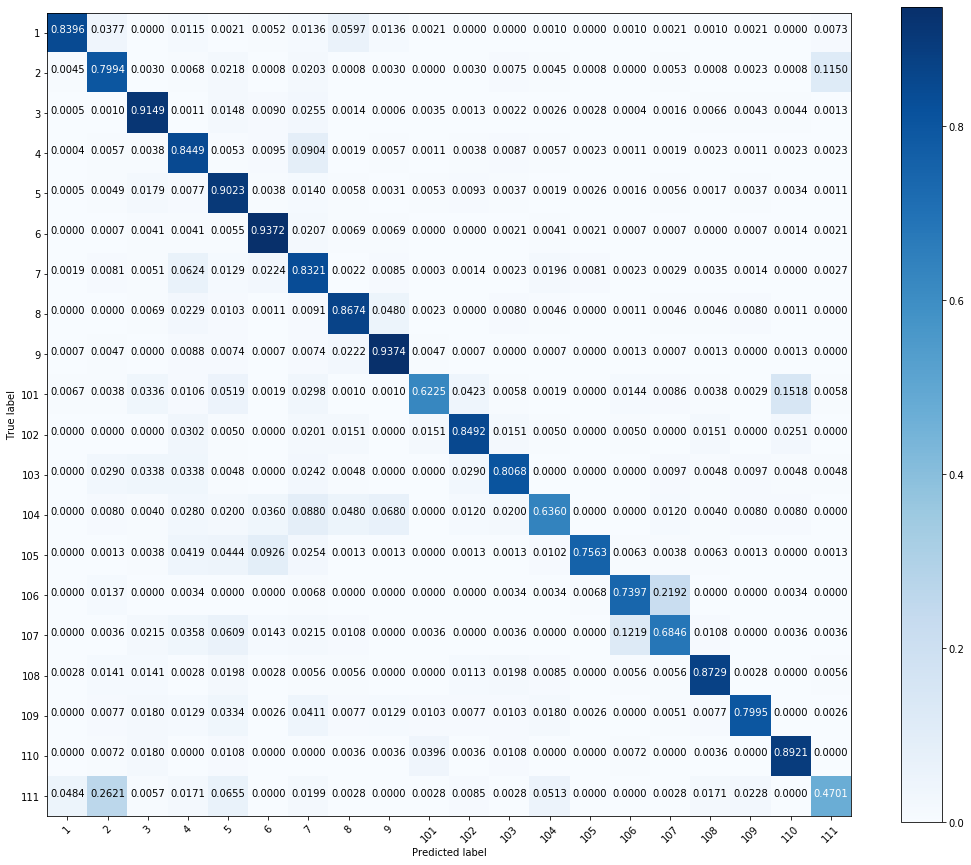

===== Model 19: num layers = 3, layer size = 128, activation = relu, learning rate = 0.001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_51 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_52 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_53 (Dense)             (None, 20)                2580      
Total params: 166,804
Trainable params: 166,804
Non-trainable params: 0
_________________________________________________________________
None


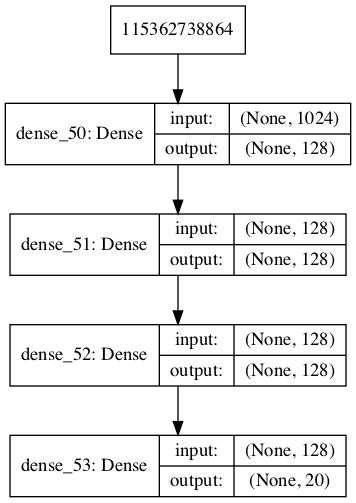

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 18s 100us/step - loss: 1.2510 - acc: 0.6444 - val_loss: 0.8565 - val_acc: 0.7634
Epoch 2/100
178346/178346 [==============================] - 14s 78us/step - loss: 0.7275 - acc: 0.7944 - val_loss: 0.6486 - val_acc: 0.8205
Epoch 3/100
178346/178346 [==============================] - 13s 72us/step - loss: 0.5850 - acc: 0.8327 - val_loss: 0.5506 - val_acc: 0.8441
Epoch 4/100
178346/178346 [==============================] - 11s 64us/step - loss: 0.5035 - acc: 0.8537 - val_loss: 0.4983 - val_acc: 0.8581
Epoch 5/100
178346/178346 [==============================] - 12s 67us/step - loss: 0.4525 - acc: 0.8669 - val_loss: 0.4670 - val_acc: 0.8452
Epoch 6/100
178346/178346 [==============================] - 11s 63us/step - loss: 0.4147 - acc: 0.8766 - val_loss: 0.4169 - val_acc: 0.8786
Epoch 7/100
178346/178346 [==============================] - 12s 65us/step - loss: 0.3828 - acc: 0.886

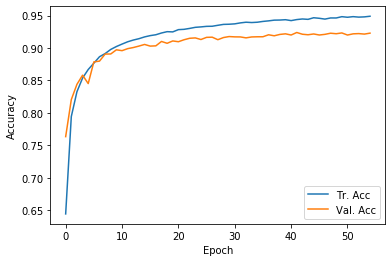

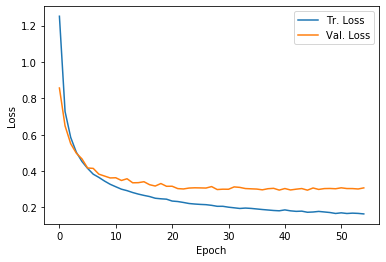

--- Test set evaluation ---
Loss              : 0.3075
Accuracy          : 0.9192
Balanced accuracy : 0.7799


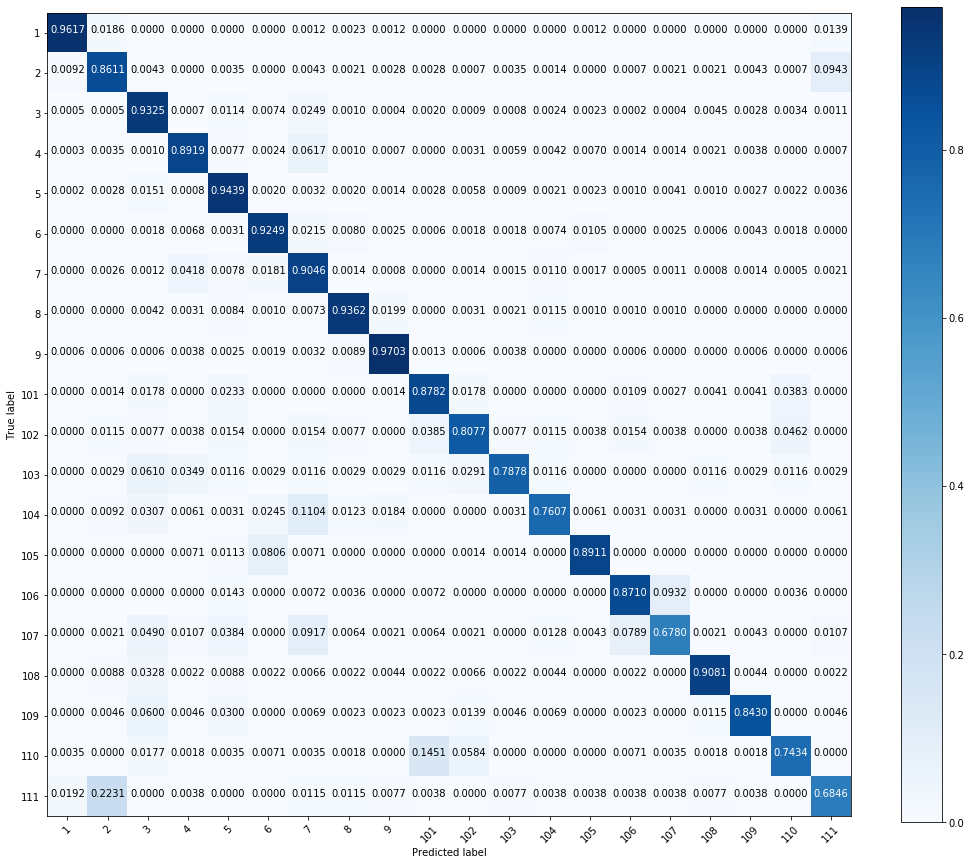

===== Model 20: num layers = 3, layer size = 128, activation = relu, learning rate = 0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_55 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_56 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_57 (Dense)             (None, 20)                2580      
Total params: 166,804
Trainable params: 166,804
Non-trainable params: 0
_________________________________________________________________
None


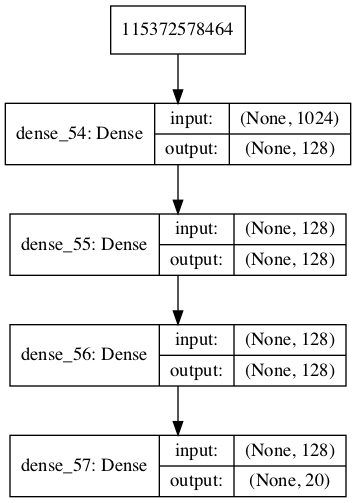

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 14s 77us/step - loss: 1.7999 - acc: 0.5023 - val_loss: 1.5188 - val_acc: 0.5495
Epoch 2/100
178346/178346 [==============================] - 12s 66us/step - loss: 1.3829 - acc: 0.5975 - val_loss: 1.2669 - val_acc: 0.6438
Epoch 3/100
178346/178346 [==============================] - 11s 63us/step - loss: 1.1784 - acc: 0.6715 - val_loss: 1.1079 - val_acc: 0.6969
Epoch 4/100
178346/178346 [==============================] - 12s 67us/step - loss: 1.0500 - acc: 0.7118 - val_loss: 1.0061 - val_acc: 0.7296
Epoch 5/100
178346/178346 [==============================] - 11s 63us/step - loss: 0.9615 - acc: 0.7361 - val_loss: 0.9315 - val_acc: 0.7421
Epoch 6/100
178346/178346 [==============================] - 14s 78us/step - loss: 0.8943 - acc: 0.7512 - val_loss: 0.8730 - val_acc: 0.7609
Epoch 7/100
178346/178346 [==============================] - 12s 68us/step - loss: 0.8392 - acc: 0.7671

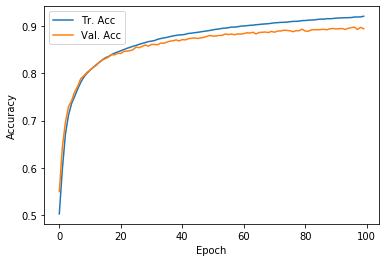

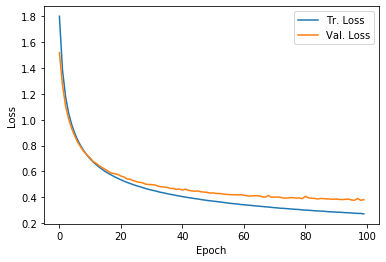

--- Test set evaluation ---
Loss              : 0.3913
Accuracy          : 0.8931
Balanced accuracy : 0.6913


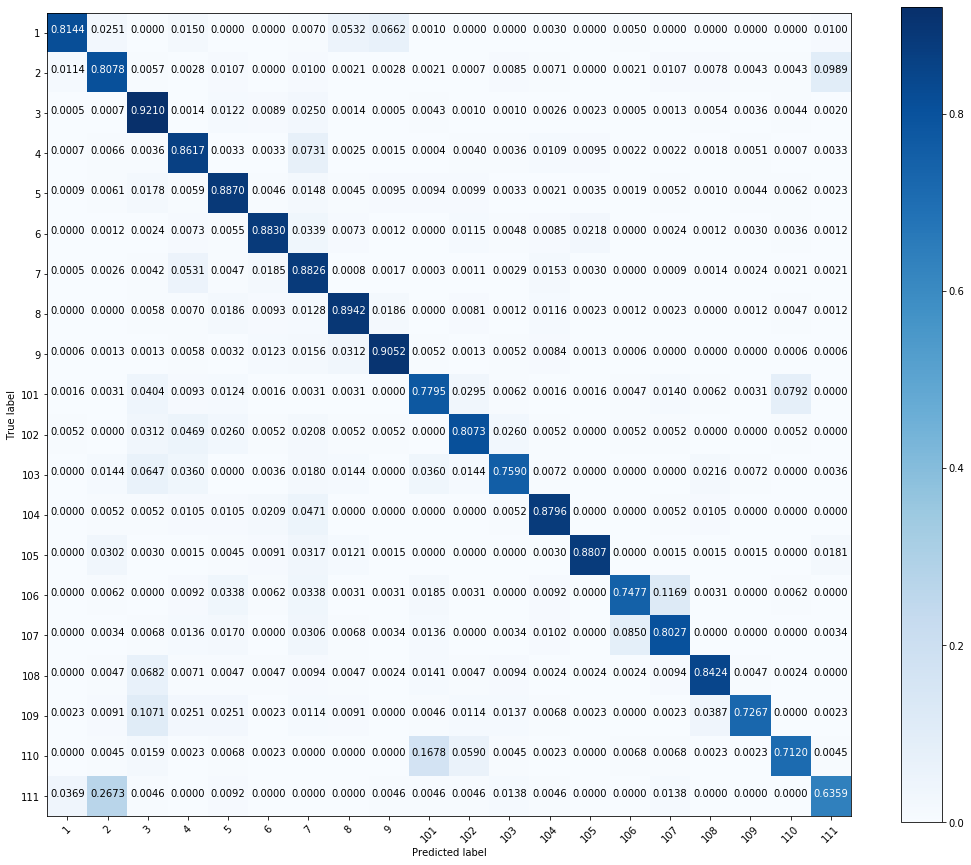

===== Model 21: num layers = 3, layer size = 256, activation = relu, learning rate = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_59 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_60 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_61 (Dense)             (None, 20)                5140      
Total params: 399,124
Trainable params: 399,124
Non-trainable params: 0
_________________________________________________________________
None


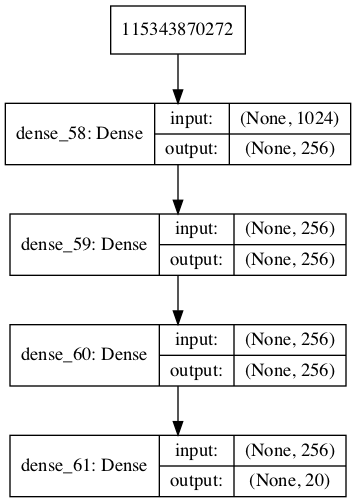

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 17s 96us/step - loss: 1.0954 - acc: 0.6963 - val_loss: 0.7355 - val_acc: 0.7901
Epoch 2/100
178346/178346 [==============================] - 17s 93us/step - loss: 0.6243 - acc: 0.8180 - val_loss: 0.5651 - val_acc: 0.8357
Epoch 3/100
178346/178346 [==============================] - 16s 90us/step - loss: 0.5261 - acc: 0.8454 - val_loss: 0.5260 - val_acc: 0.8496
Epoch 4/100
178346/178346 [==============================] - 23s 128us/step - loss: 0.4798 - acc: 0.8590 - val_loss: 0.5010 - val_acc: 0.8556
Epoch 5/100
178346/178346 [==============================] - 17s 96us/step - loss: 0.4539 - acc: 0.8651 - val_loss: 0.4957 - val_acc: 0.8608
Epoch 6/100
178346/178346 [==============================] - 17s 96us/step - loss: 0.4328 - acc: 0.8718 - val_loss: 0.4443 - val_acc: 0.8729
Epoch 7/100
178346/178346 [==============================] - 15s 84us/step - loss: 0.4118 - acc: 0.877

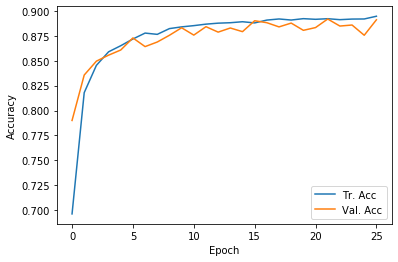

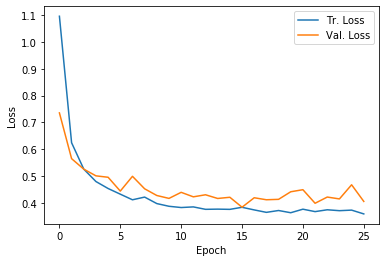

--- Test set evaluation ---
Loss              : 0.3919
Accuracy          : 0.8884
Balanced accuracy : 0.6869


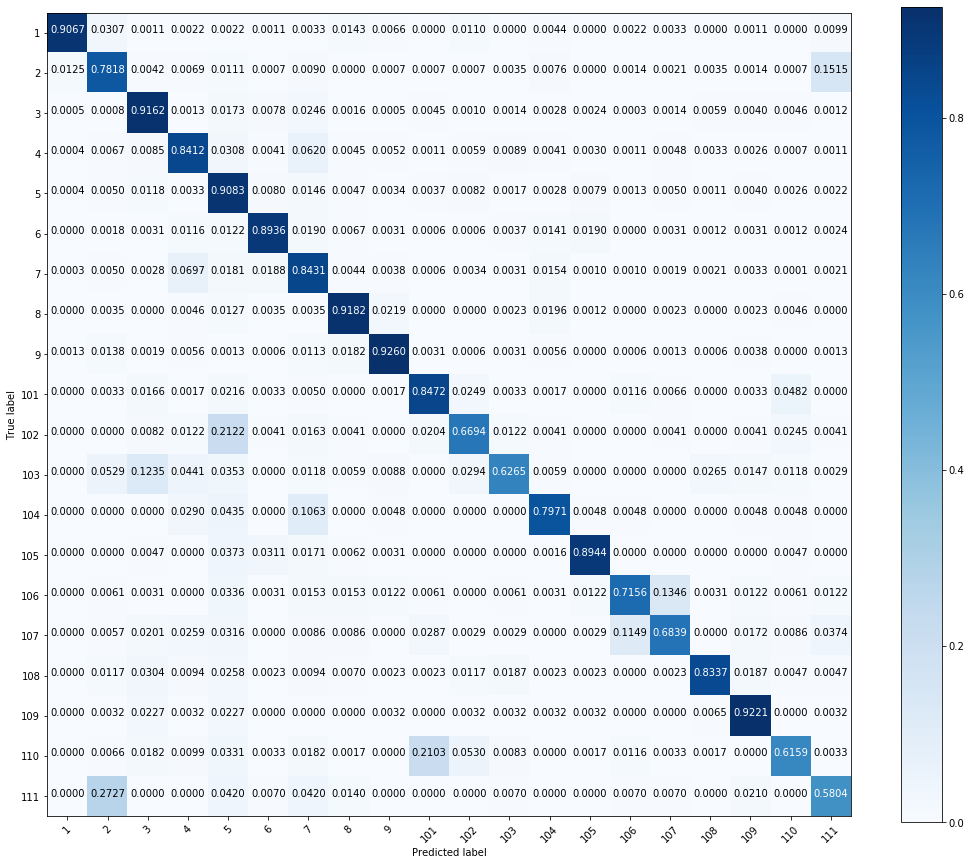

===== Model 22: num layers = 3, layer size = 256, activation = relu, learning rate = 0.001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_63 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_64 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_65 (Dense)             (None, 20)                5140      
Total params: 399,124
Trainable params: 399,124
Non-trainable params: 0
_________________________________________________________________
None


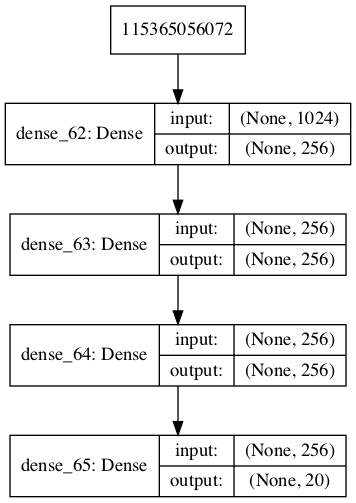

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 18s 99us/step - loss: 1.0680 - acc: 0.6948 - val_loss: 0.7060 - val_acc: 0.8018
Epoch 2/100
178346/178346 [==============================] - 15s 85us/step - loss: 0.6007 - acc: 0.8270 - val_loss: 0.5213 - val_acc: 0.8524
Epoch 3/100
178346/178346 [==============================] - 15s 84us/step - loss: 0.4754 - acc: 0.8614 - val_loss: 0.4586 - val_acc: 0.8674
Epoch 4/100
178346/178346 [==============================] - 19s 105us/step - loss: 0.4067 - acc: 0.8792 - val_loss: 0.4121 - val_acc: 0.8752
Epoch 5/100
178346/178346 [==============================] - 16s 90us/step - loss: 0.3622 - acc: 0.8906 - val_loss: 0.3731 - val_acc: 0.8877
Epoch 6/100
178346/178346 [==============================] - 16s 88us/step - loss: 0.3309 - acc: 0.9004 - val_loss: 0.3601 - val_acc: 0.8949
Epoch 7/100
178346/178346 [==============================] - 16s 90us/step - loss: 0.3059 - acc: 0.907

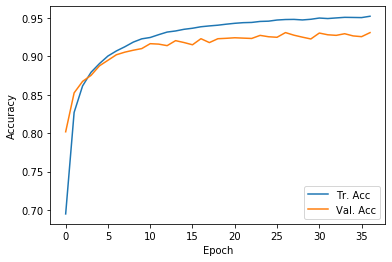

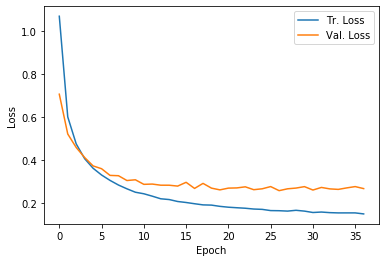

--- Test set evaluation ---
Loss              : 0.2644
Accuracy          : 0.9291
Balanced accuracy : 0.8089


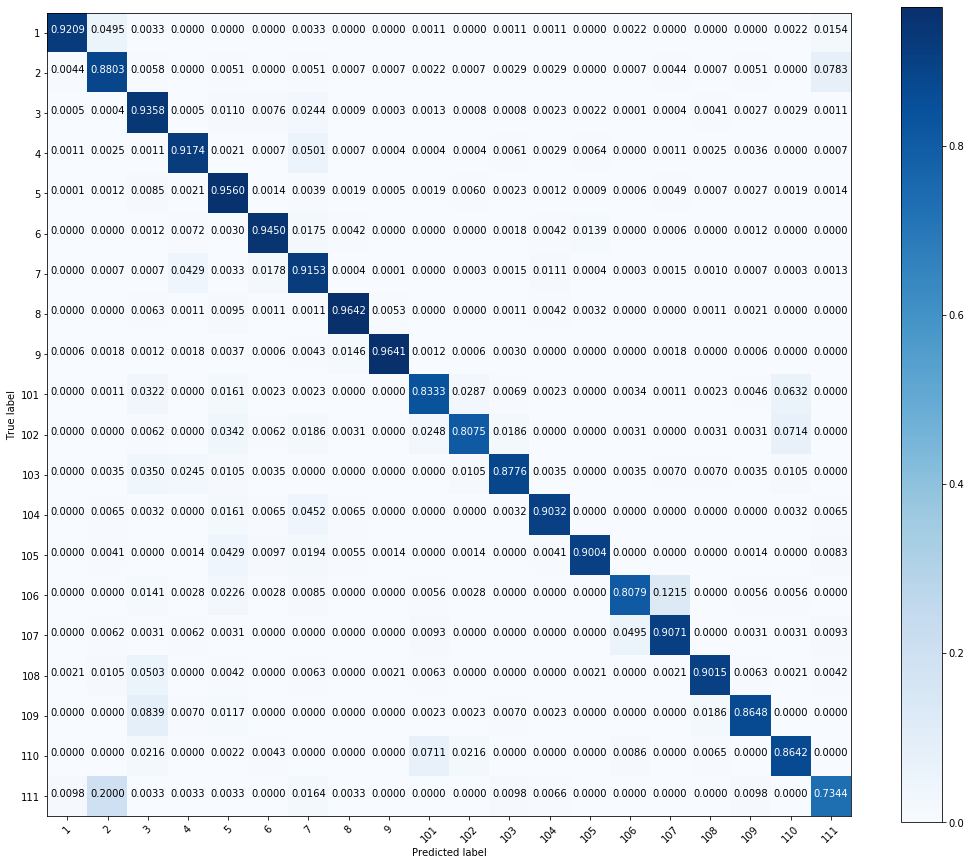

===== Model 23: num layers = 3, layer size = 256, activation = relu, learning rate = 0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_67 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_68 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_69 (Dense)             (None, 20)                5140      
Total params: 399,124
Trainable params: 399,124
Non-trainable params: 0
_________________________________________________________________
None


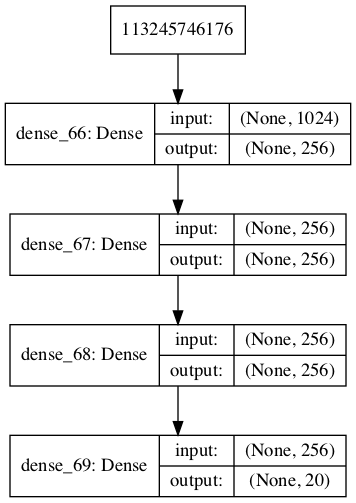

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 17s 98us/step - loss: 1.6202 - acc: 0.5369 - val_loss: 1.3145 - val_acc: 0.6349
Epoch 2/100
178346/178346 [==============================] - 16s 88us/step - loss: 1.1578 - acc: 0.6765 - val_loss: 1.0366 - val_acc: 0.7131
Epoch 3/100
178346/178346 [==============================] - 17s 93us/step - loss: 0.9502 - acc: 0.7385 - val_loss: 0.8820 - val_acc: 0.7542
Epoch 4/100
178346/178346 [==============================] - 20s 112us/step - loss: 0.8312 - acc: 0.7684 - val_loss: 0.7955 - val_acc: 0.7787
Epoch 5/100
178346/178346 [==============================] - 15s 85us/step - loss: 0.7505 - acc: 0.7926 - val_loss: 0.7238 - val_acc: 0.8038
Epoch 6/100
178346/178346 [==============================] - 15s 87us/step - loss: 0.6911 - acc: 0.8090 - val_loss: 0.6795 - val_acc: 0.8141
Epoch 7/100
178346/178346 [==============================] - 15s 84us/step - loss: 0.6447 - acc: 0.821

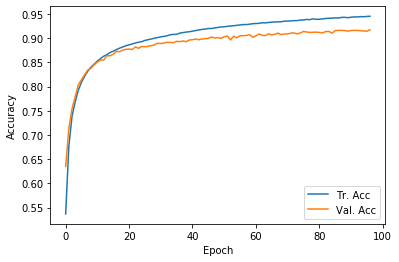

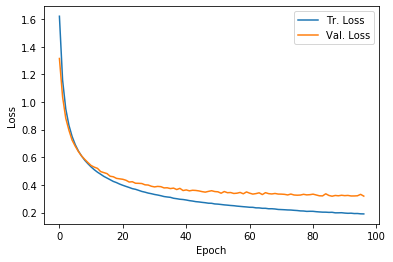

--- Test set evaluation ---
Loss              : 0.3264
Accuracy          : 0.9136
Balanced accuracy : 0.7528


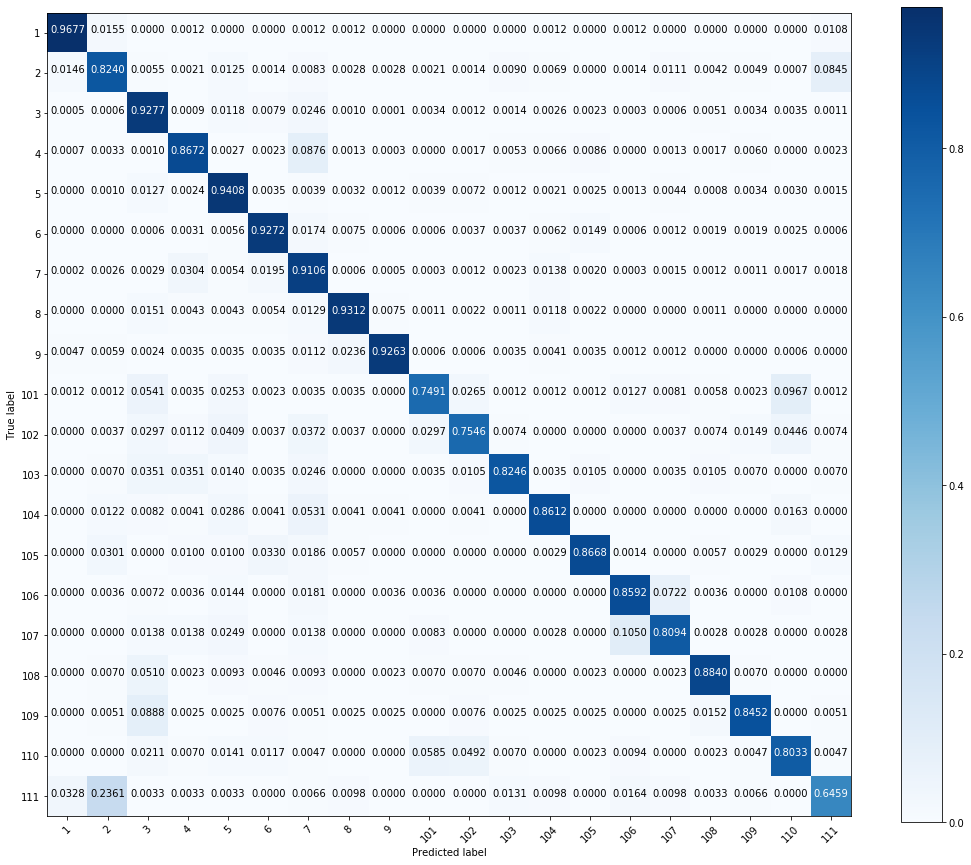

===== Model 24: num layers = 3, layer size = 512, activation = relu, learning rate = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_71 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_72 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_73 (Dense)             (None, 20)                10260     
Total params: 1,060,372
Trainable params: 1,060,372
Non-trainable params: 0
_________________________________________________________________
None


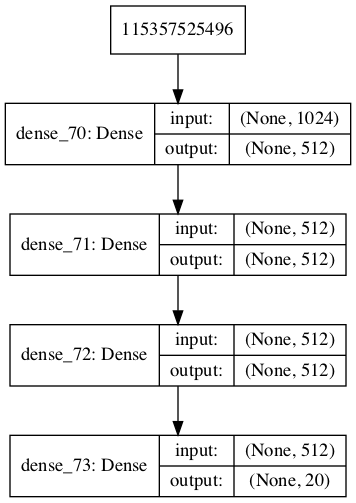

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 31s 172us/step - loss: 7.2949 - acc: 0.4720 - val_loss: 1.9012 - val_acc: 0.4781
Epoch 2/100
178346/178346 [==============================] - 29s 165us/step - loss: 1.9023 - acc: 0.4772 - val_loss: 1.8994 - val_acc: 0.4781
Epoch 3/100
178346/178346 [==============================] - 31s 173us/step - loss: 1.9001 - acc: 0.4772 - val_loss: 1.8969 - val_acc: 0.4781
Epoch 4/100
178346/178346 [==============================] - 28s 154us/step - loss: 1.8987 - acc: 0.4772 - val_loss: 1.8989 - val_acc: 0.4781
Epoch 5/100
178346/178346 [==============================] - 28s 157us/step - loss: 1.8997 - acc: 0.4772 - val_loss: 1.9022 - val_acc: 0.4781
Epoch 6/100
178346/178346 [==============================] - 29s 162us/step - loss: 1.8991 - acc: 0.4772 - val_loss: 1.8978 - val_acc: 0.4781
Epoch 7/100
178346/178346 [==============================] - 29s 160us/step - loss: 1.8986 - acc:

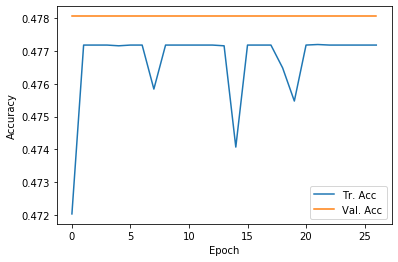

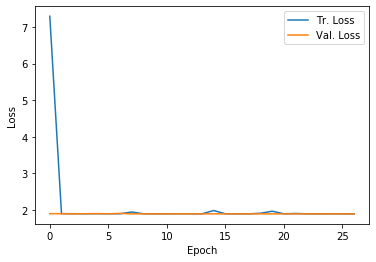

--- Test set evaluation ---
Loss              : 1.8980
Accuracy          : 0.4763
Balanced accuracy : 0.0500


/Users/david/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


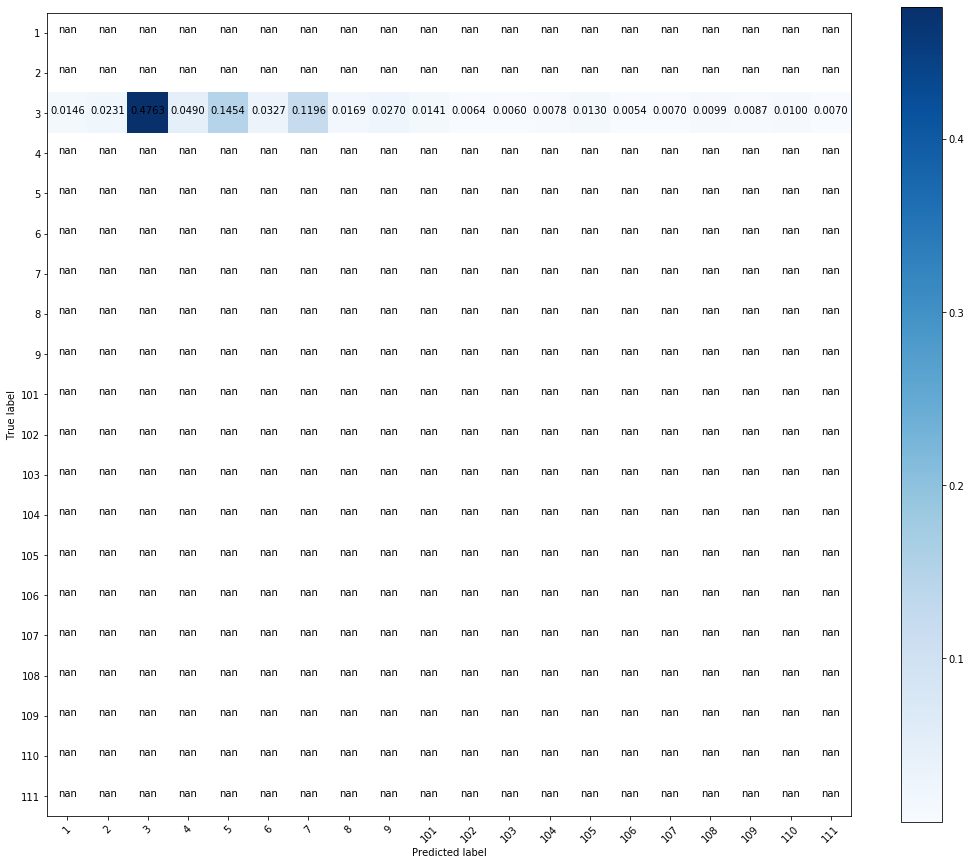

===== Model 25: num layers = 3, layer size = 512, activation = relu, learning rate = 0.001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_75 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_76 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_77 (Dense)             (None, 20)                10260     
Total params: 1,060,372
Trainable params: 1,060,372
Non-trainable params: 0
_________________________________________________________________
None


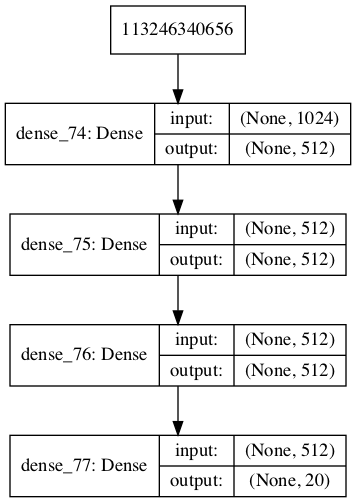

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 31s 173us/step - loss: 0.9511 - acc: 0.7255 - val_loss: 0.6107 - val_acc: 0.8314
Epoch 2/100
178346/178346 [==============================] - 32s 178us/step - loss: 0.5241 - acc: 0.8466 - val_loss: 0.4488 - val_acc: 0.8701
Epoch 3/100
178346/178346 [==============================] - 29s 163us/step - loss: 0.4112 - acc: 0.8777 - val_loss: 0.3982 - val_acc: 0.8832
Epoch 4/100
178346/178346 [==============================] - 28s 154us/step - loss: 0.3502 - acc: 0.8946 - val_loss: 0.3617 - val_acc: 0.8935
Epoch 5/100
178346/178346 [==============================] - 28s 158us/step - loss: 0.3077 - acc: 0.9058 - val_loss: 0.3262 - val_acc: 0.9018
Epoch 6/100
178346/178346 [==============================] - 29s 161us/step - loss: 0.2784 - acc: 0.9139 - val_loss: 0.3039 - val_acc: 0.9097
Epoch 7/100
178346/178346 [==============================] - 28s 156us/step - loss: 0.2541 - acc:

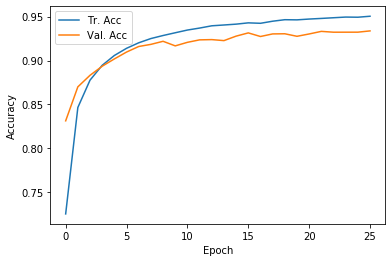

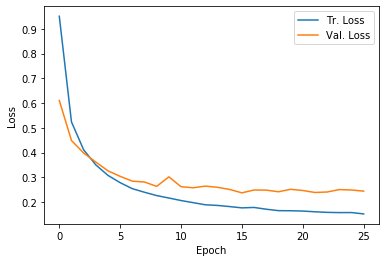

--- Test set evaluation ---
Loss              : 0.2479
Accuracy          : 0.9289
Balanced accuracy : 0.8154


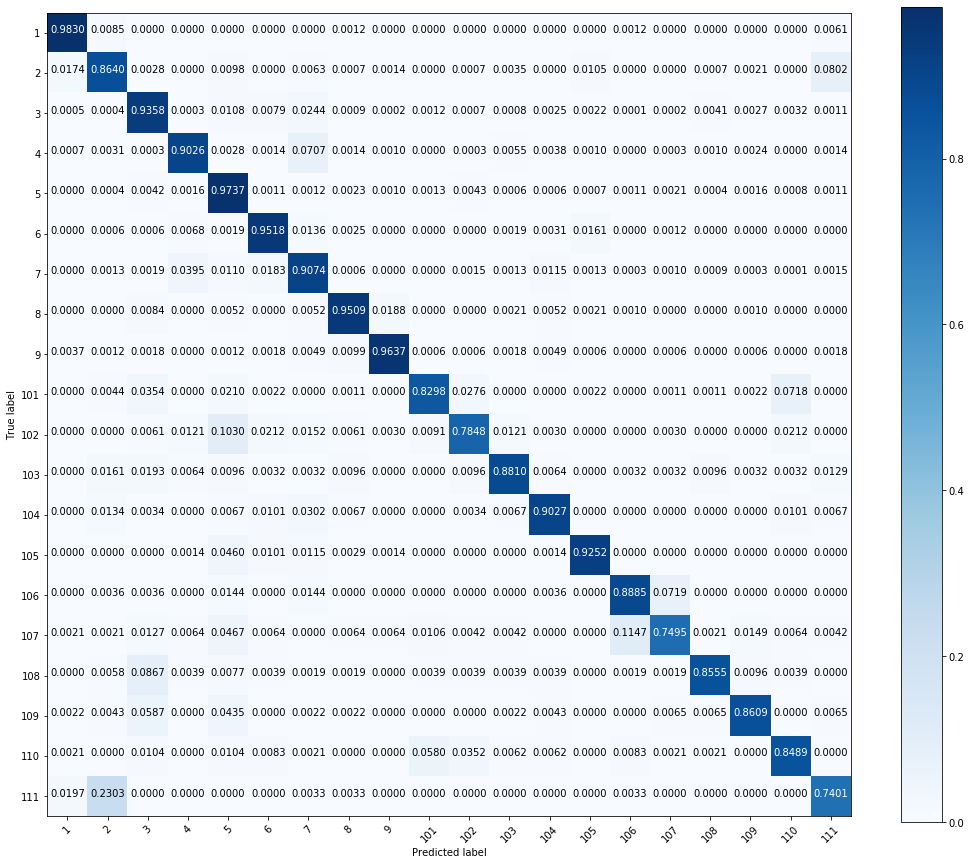

===== Model 26: num layers = 3, layer size = 512, activation = relu, learning rate = 0.0001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_79 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_80 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_81 (Dense)             (None, 20)                10260     
Total params: 1,060,372
Trainable params: 1,060,372
Non-trainable params: 0
_________________________________________________________________
None


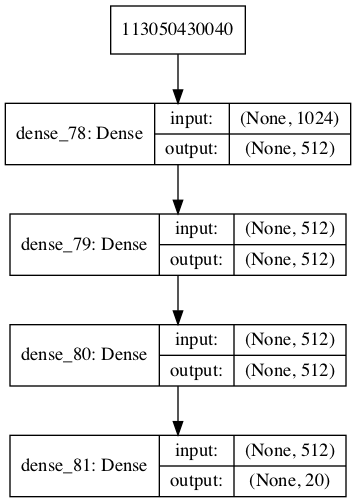

Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 33s 188us/step - loss: 1.4251 - acc: 0.5908 - val_loss: 1.0894 - val_acc: 0.6996
Epoch 2/100
178346/178346 [==============================] - 29s 160us/step - loss: 0.9398 - acc: 0.7387 - val_loss: 0.8245 - val_acc: 0.7706
Epoch 3/100
178346/178346 [==============================] - 30s 167us/step - loss: 0.7549 - acc: 0.7872 - val_loss: 0.7069 - val_acc: 0.8045
Epoch 4/100
178346/178346 [==============================] - 29s 165us/step - loss: 0.6520 - acc: 0.8161 - val_loss: 0.6286 - val_acc: 0.8276
Epoch 5/100
178346/178346 [==============================] - 29s 164us/step - loss: 0.5844 - acc: 0.8367 - val_loss: 0.5782 - val_acc: 0.8382
Epoch 6/100
178346/178346 [==============================] - 30s 169us/step - loss: 0.5373 - acc: 0.8490 - val_loss: 0.5387 - val_acc: 0.8505
Epoch 7/100
178346/178346 [==============================] - 32s 181us/step - loss: 0.5015 - acc:

Epoch 58/100
178346/178346 [==============================] - 29s 160us/step - loss: 0.1902 - acc: 0.9439 - val_loss: 0.3032 - val_acc: 0.9181
Epoch 59/100
178346/178346 [==============================] - 33s 187us/step - loss: 0.1880 - acc: 0.9447 - val_loss: 0.3077 - val_acc: 0.9182
Epoch 60/100
178346/178346 [==============================] - 28s 155us/step - loss: 0.1875 - acc: 0.9449 - val_loss: 0.3109 - val_acc: 0.9171
Epoch 61/100
178346/178346 [==============================] - 28s 158us/step - loss: 0.1860 - acc: 0.9449 - val_loss: 0.3054 - val_acc: 0.9160


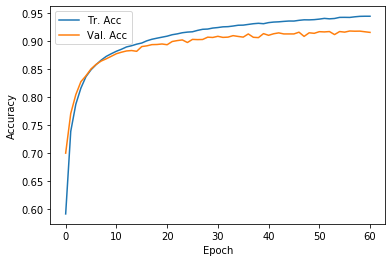

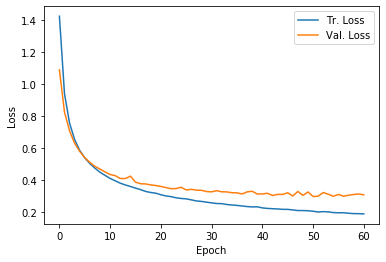

--- Test set evaluation ---
Loss              : 0.3065
Accuracy          : 0.9147
Balanced accuracy : 0.7590


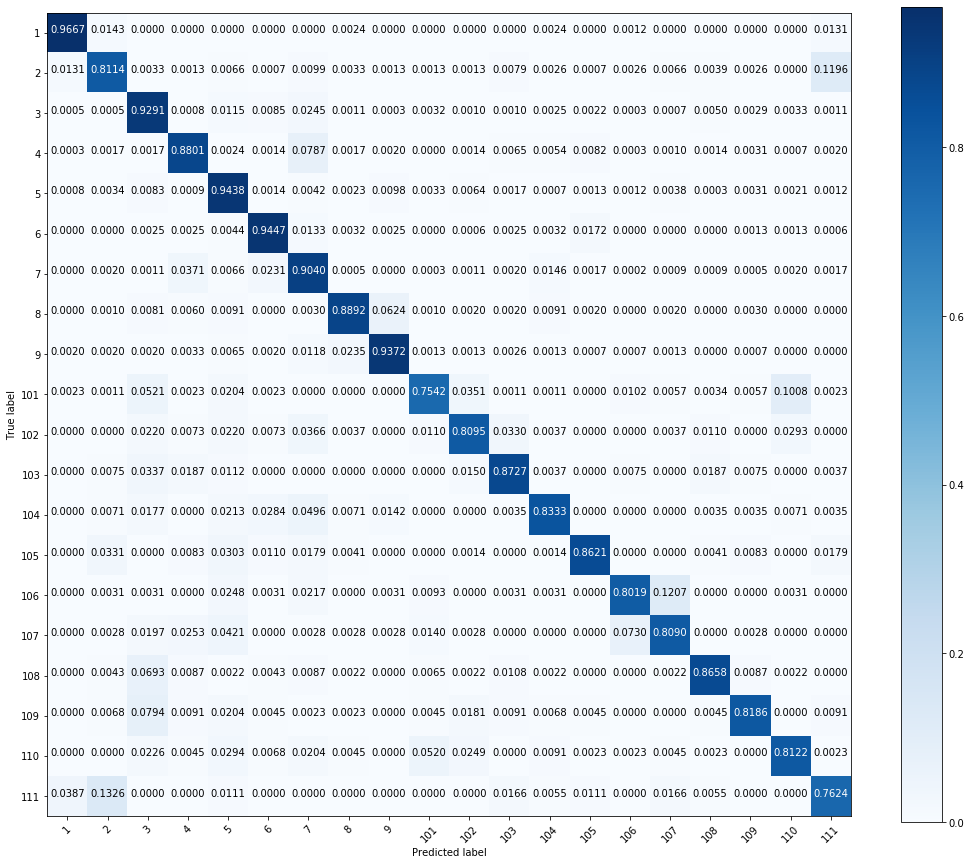

Elapsed time: 24458.24 seconds (6.79 hours)


In [11]:
if TRAIN_ALL:
    # how long does this take?
    start_time = time.time()

    # gather training stats
    stats_dir = os.path.join(os.getcwd(), "stats")
    if not os.path.exists(stats_dir):
        os.makedirs(stats_dir)

    stats_path = os.path.join(stats_dir, "training_stats.csv")
    stats_file = open(stats_path, "w+")
    stats_file.write(
        "Model,Parameters,Training Epoch,Training Loss,Training Accuracy,Test Loss,Test Accuracy,Balanced Test Accuracy\n")

    # gather model stats
    models_dir = os.path.join(os.getcwd(), "models")
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    models_path = os.path.join(models_dir, "models.csv")
    models_file = open(models_path, "w+")
    models_file.write("Model,Num Layers,Layer Sizes,Activation,Learning Rate\n")

    # stop early if possible
    callbacks = [EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        restore_best_weights = True
    )]

    # this'll take a while
    count = 0
    for n in num_hidden_layers:
        for w in hidden_layer_widths:
            for a in activation_functions:
                for l in learning_rates:
                    print("{}\n{} Model {}: num layers = {}, layer size = {}, activation = {}, learning rate = {}\n{}".format(
                        "=" * 100, "=" * 5, count, n, w, a, l, "=" * 100))

                    # filepaths
                    model_name = "model_{}".format(count)

                    # build and show model
                    model = build_model(n, w, a, l, model_name)

                    # we'll need these
                    train_x = all_train_x
                    train_y = all_train_y
                    val_x = all_val_x
                    val_y = all_val_y
                    test_x = all_test_x
                    test_y = all_test_y

                    # and these
                    y_ints = [y.argmax() for y in all_train_y]
                    class_weights = class_weight.compute_class_weight("balanced", np.unique(y_ints), y_ints)

                    # train model
                    history = model.fit(
                        train_x, train_y,
                        validation_data = (val_x, val_y),
                        class_weight = class_weights,
                        batch_size = 512,
                        epochs = 100,
                        shuffle = True,
                        verbose = 1,
                        callbacks = callbacks)

                    # save trained model
                    save_model(model, model_name)

                    # show the graph history
                    graph_history(history, model_name, validation_data=True)

                    # evaluate the model
                    evaluation = model.evaluate(test_x, all_test_y, verbose=0)

                    print("--- Test set evaluation ---")
                    print("Loss              : {:.4f}".format(evaluation[0]))
                    print("Accuracy          : {:.4f}".format(evaluation[1]))

                    # predict the test set and save the labels
                    actual_labels = np.argmax(test_y, axis=1)
                    predicted_labels = np.argmax(model.predict(test_x), axis=1)
                    balanced_acc = balanced_accuracy_score(actual_labels, predicted_labels)

                    print("Balanced accuracy : {:.4f}".format(balanced_acc))

                    # revert to the original vehicle IDs
                    actual_labels = [old_labels[i] for i in actual_labels]
                    predicted_labels = [old_labels[i] for i in predicted_labels]

                    # generate, save, and display confusion matrix
                    cm = confusion_matrix(predicted_labels, actual_labels)
                    plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)

                    # get stats
                    params = model.count_params()
                    best_epoch = np.argmin(history.history["val_loss"])
                    best_loss = history.history["val_loss"][best_epoch]
                    best_acc = history.history["val_acc"][best_epoch]

                    # save stats
                    stats = [count, params, best_epoch, best_loss, best_acc, evaluation[0], evaluation[1], balanced_acc]
                    stats_file.write(",".join([str(s) for s in stats]) + "\n")

                    # save model metadata
                    model_metadata = [count, n, w, a, l]
                    models_file.write(",".join([str(d) for d in model_metadata]) + "\n")

                    # next model
                    count += 1

    stats_file.close()
    models_file.close()

    elapsed_time = time.time() - start_time
    print("Elapsed time: {:.2f} seconds ({:.2f} hours)".format(elapsed_time, elapsed_time / 3600.))

## Train and test the best model

Model               25
Num Layers           3
Layer Sizes        512
Activation        relu
Learning Rate    0.001
Name: 25, dtype: object
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_24 (Dense)             (None, 20)                10260     
Total params: 1,060,372
Trainable params: 1,060,372
Non-trainable params: 0
_________________________________________________________________
None
Train on 178346 samples, validate on 59449 samples
Epoch 1/100
178346/178346 [==============================] - 38s 211u

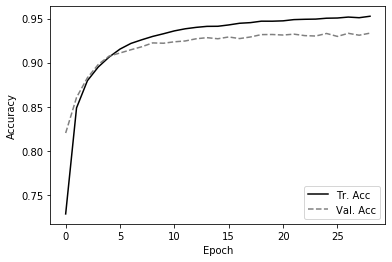

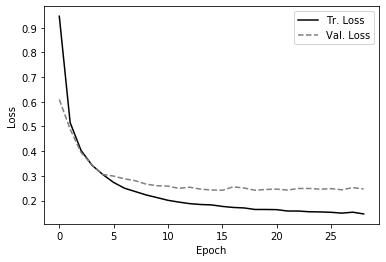

In [15]:
if TRAIN_BEST:
    # stop early if possible
    callbacks = [EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        restore_best_weights = True
    )]
    
    for dataset in ["all"]:
        # best model
        training_stats = pd.read_csv(os.path.join(os.getcwd(), "stats", "training_stats.csv"))
        best_model = int(training_stats.sort_values(by=["Training Loss"]).iloc[0]["Model"])
        best_epoch = int(training_stats.sort_values(by=["Training Loss"]).iloc[0]["Training Epoch"])
        
        # model parameters
        model_params = pd.read_csv(os.path.join(os.getcwd(), "models", "models.csv"))
        best_model = model_params.iloc[best_model]
        print(best_model)

        # filepaths
        model_name = "final_model_all" if dataset == "all" else "final_model_balanced"

        # build and show model
        model = build_model(best_model["Num Layers"], best_model["Layer Sizes"],
            best_model["Activation"], best_model["Learning Rate"], model_name)

        # we'll need these
        train_x = all_train_x if dataset == "all" else balanced_train_x
        train_y = all_train_y if dataset == "all" else balanced_train_y
        val_x = all_val_x if dataset == "all" else balanced_val_x
        val_y = all_val_y if dataset == "all" else balanced_val_y
        test_x = all_test_x if dataset == "all" else balanced_test_x
        test_y = all_test_y if dataset == "all" else balanced_test_y

        # and these
        y_ints = [y.argmax() for y in all_train_y]
        class_weights = class_weight.compute_class_weight("balanced", np.unique(y_ints), y_ints)
        class_weights = class_weights if dataset == "all" else None

        # train model
        history = model.fit(
            train_x, train_y,
            validation_data = (val_x, val_y),
            class_weight = class_weights,
            batch_size = 512,
            epochs = 100,
            shuffle = True,
            verbose = 1,
            callbacks = callbacks)
        
#         history = model.fit(
#             np.concatenate((train_x, val_x)), np.concatenate((train_y, val_y)),
#             class_weight = class_weights,
#             batch_size = 512,
#             epochs = best_epoch,
#             shuffle = True,
#             verbose = 1)

#         # save trained model
#         save_model(model, model_name)

        # show the graph history
        graph_history(history, model_name, validation_data=True)

#         # evaluate the model
#         evaluation = model.evaluate(test_x, test_y, verbose=0)

#         print("--- Test set evaluation ---")
#         print("Loss              : {:.4f}".format(evaluation[0]))
#         print("Accuracy          : {:.4f}".format(evaluation[1]))

#         # predict the test set and save the labels
#         actual_labels = np.argmax(test_y, axis=1)
#         predicted_labels = np.argmax(model.predict(test_x), axis=1)

#         print("Balanced accuracy : {:.4f}".format(balanced_accuracy_score(actual_labels, predicted_labels)))

#         # revert to the original vehicle IDs
#         actual_labels = [old_labels[i] for i in actual_labels]
#         predicted_labels = [old_labels[i] for i in predicted_labels]

#         # generate, save, and display confusion matrix
#         cm = confusion_matrix(predicted_labels, actual_labels)
#         plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)

Model               25
Num Layers           3
Layer Sizes        512
Activation        relu
Learning Rate    0.001
Name: 25, dtype: object
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_87 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_88 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_89 (Dense)             (None, 20)                10260     
Total params: 1,060,372
Trainable params: 1,060,372
Non-trainable params: 0
_________________________________________________________________
None


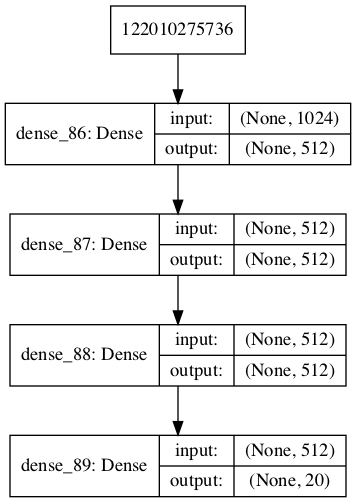

Epoch 1/15
237795/237795 [==============================] - 38s 161us/step - loss: 0.8673 - acc: 0.7508
Epoch 2/15
237795/237795 [==============================] - 34s 143us/step - loss: 0.4684 - acc: 0.8628
Epoch 3/15
237795/237795 [==============================] - 35s 147us/step - loss: 0.3654 - acc: 0.8903
Epoch 4/15
237795/237795 [==============================] - 35s 149us/step - loss: 0.3101 - acc: 0.9057
Epoch 5/15
237795/237795 [==============================] - 35s 148us/step - loss: 0.2731 - acc: 0.9163
Epoch 6/15
237795/237795 [==============================] - 35s 149us/step - loss: 0.2484 - acc: 0.9226
Epoch 7/15
237795/237795 [==============================] - 34s 145us/step - loss: 0.2296 - acc: 0.9279
Epoch 8/15
237795/237795 [==============================] - 35s 147us/step - loss: 0.2179 - acc: 0.9311
Epoch 9/15
237795/237795 [==============================] - 35s 146us/step - loss: 0.2065 - acc: 0.9345
Epoch 10/15
237795/237795 [==============================] - 42s

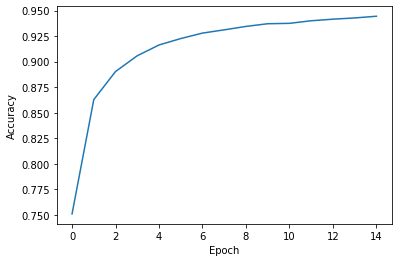

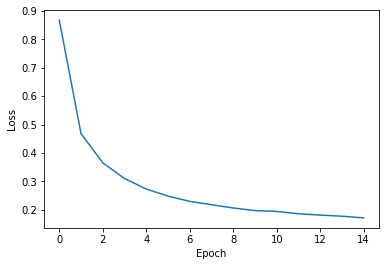

--- Test set evaluation ---
Loss              : 0.2440
Accuracy          : 0.9316
Balanced accuracy : 0.8171


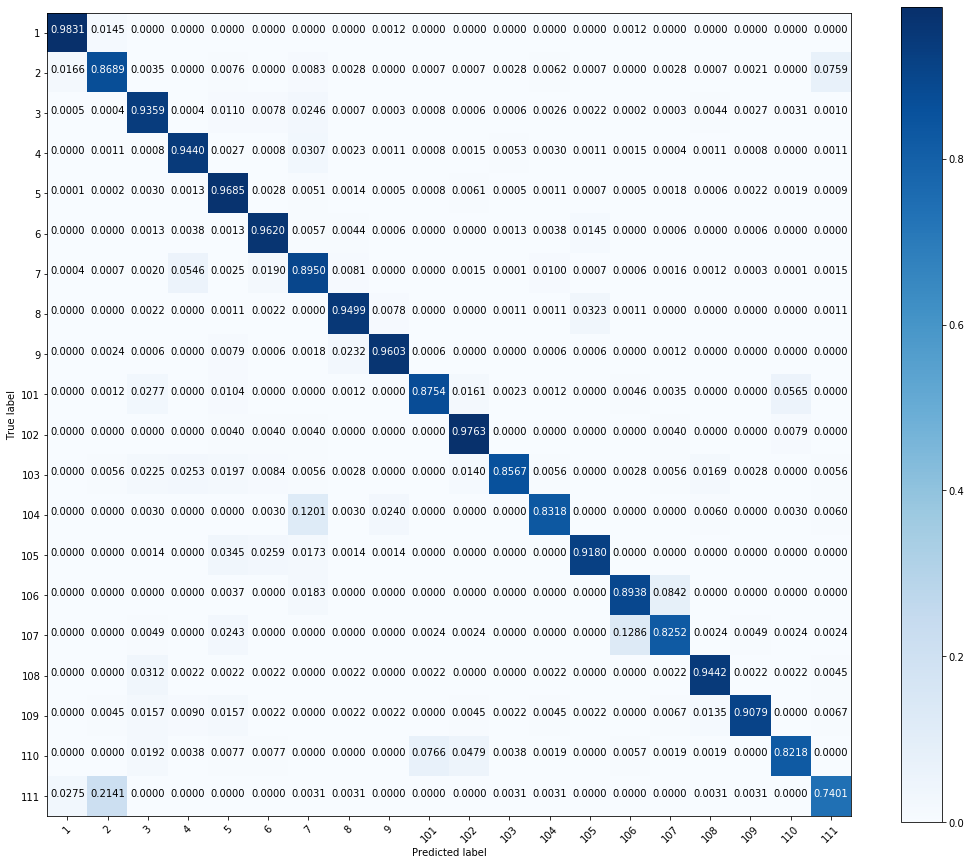

Model               25
Num Layers           3
Layer Sizes        512
Activation        relu
Learning Rate    0.001
Name: 25, dtype: object
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_91 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_92 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_93 (Dense)             (None, 20)                10260     
Total params: 1,060,372
Trainable params: 1,060,372
Non-trainable params: 0
_________________________________________________________________
None


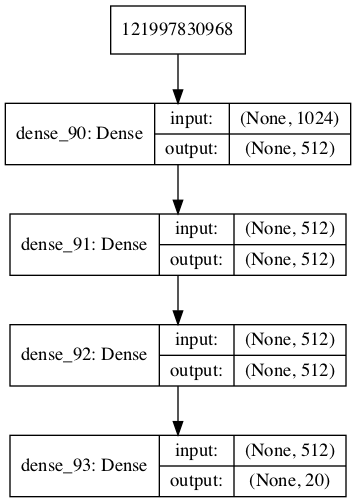

Epoch 1/15
27120/27120 [==============================] - 8s 287us/step - loss: 2.2641 - acc: 0.3101
Epoch 2/15
27120/27120 [==============================] - 4s 144us/step - loss: 1.5058 - acc: 0.5254
Epoch 3/15
27120/27120 [==============================] - 4s 138us/step - loss: 1.2050 - acc: 0.6154
Epoch 4/15
27120/27120 [==============================] - 4s 155us/step - loss: 1.0353 - acc: 0.6677
Epoch 5/15
27120/27120 [==============================] - 5s 169us/step - loss: 0.9209 - acc: 0.6992
Epoch 6/15
27120/27120 [==============================] - 4s 148us/step - loss: 0.8344 - acc: 0.7232
Epoch 7/15
27120/27120 [==============================] - 5s 177us/step - loss: 0.7829 - acc: 0.7400
Epoch 8/15
27120/27120 [==============================] - 4s 139us/step - loss: 0.7030 - acc: 0.7649
Epoch 9/15
27120/27120 [==============================] - 4s 140us/step - loss: 0.6403 - acc: 0.7847
Epoch 10/15
27120/27120 [==============================] - 4s 139us/step - loss: 0.6073 - a

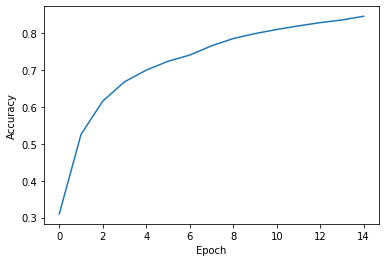

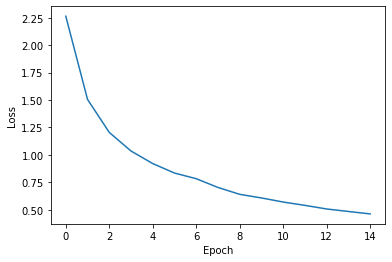

--- Test set evaluation ---
Loss              : 0.7417
Accuracy          : 0.7686
Balanced accuracy : 0.7695


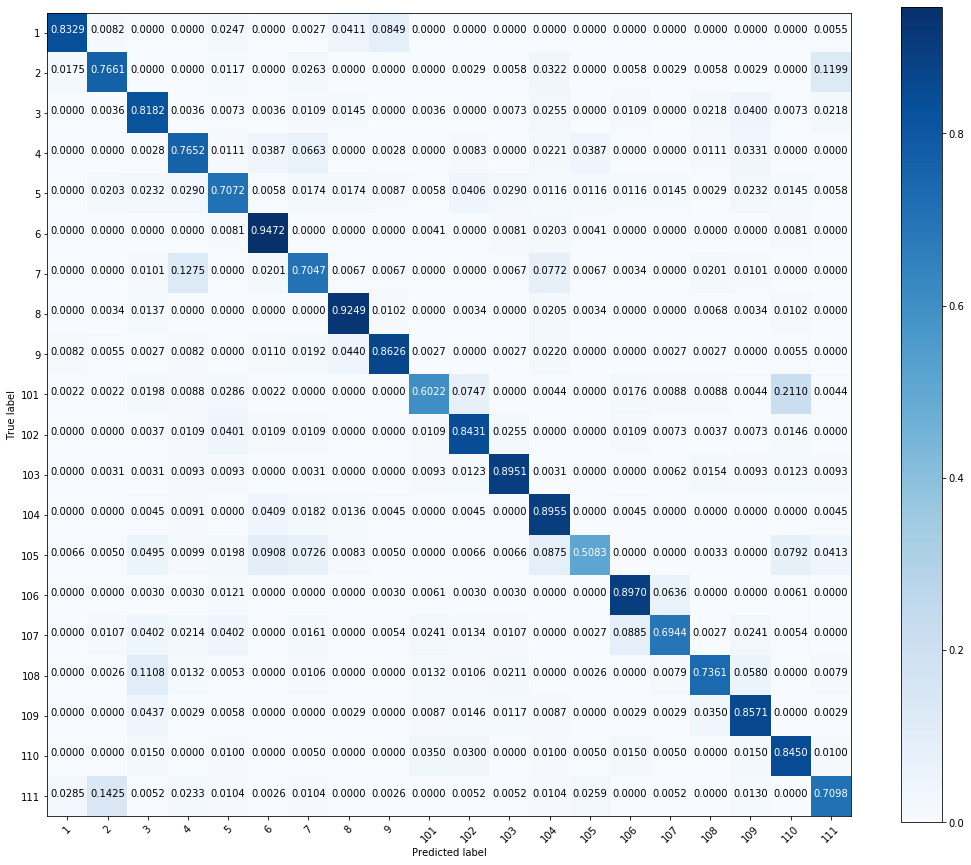

In [13]:
if TRAIN_BEST:
    for dataset in ["all", "balanced"]:
        # best model
        training_stats = pd.read_csv(os.path.join(os.getcwd(), "stats", "training_stats.csv"))
        best_model = int(training_stats.sort_values(by=["Training Loss"]).iloc[0]["Model"])
        best_epoch = int(training_stats.sort_values(by=["Training Loss"]).iloc[0]["Training Epoch"])
        
        # model parameters
        model_params = pd.read_csv(os.path.join(os.getcwd(), "models", "models.csv"))
        best_model = model_params.iloc[best_model]
        print(best_model)

        # filepaths
        model_name = "final_model_all" if dataset == "all" else "final_model_balanced"

        # build and show model
        model = build_model(best_model["Num Layers"], best_model["Layer Sizes"],
            best_model["Activation"], best_model["Learning Rate"], model_name)

        # we'll need these
        train_x = all_train_x if dataset == "all" else balanced_train_x
        train_y = all_train_y if dataset == "all" else balanced_train_y
        val_x = all_val_x if dataset == "all" else balanced_val_x
        val_y = all_val_y if dataset == "all" else balanced_val_y
        test_x = all_test_x if dataset == "all" else balanced_test_x
        test_y = all_test_y if dataset == "all" else balanced_test_y

        # and these
        y_ints = [y.argmax() for y in all_train_y]
        class_weights = class_weight.compute_class_weight("balanced", np.unique(y_ints), y_ints)
        class_weights = class_weights if dataset == "all" else None

        # train model
        history = model.fit(
            np.concatenate((train_x, val_x)), np.concatenate((train_y, val_y)),
            class_weight = class_weights,
            batch_size = 512,
            epochs = best_epoch,
            shuffle = True,
            verbose = 1)

        # save trained model
        save_model(model, model_name)

        # show the graph history
        graph_history(history, model_name)

        # evaluate the model
        evaluation = model.evaluate(test_x, test_y, verbose=0)

        print("--- Test set evaluation ---")
        print("Loss              : {:.4f}".format(evaluation[0]))
        print("Accuracy          : {:.4f}".format(evaluation[1]))

        # predict the test set and save the labels
        actual_labels = np.argmax(test_y, axis=1)
        predicted_labels = np.argmax(model.predict(test_x), axis=1)

        print("Balanced accuracy : {:.4f}".format(balanced_accuracy_score(actual_labels, predicted_labels)))

        # revert to the original vehicle IDs
        actual_labels = [old_labels[i] for i in actual_labels]
        predicted_labels = [old_labels[i] for i in predicted_labels]

        # generate, save, and display confusion matrix
        cm = confusion_matrix(predicted_labels, actual_labels)
        plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)

## Load and test the best model

In [14]:
if not TRAIN_BEST:
    for dataset in ["all", "balanced"]:
        # we'll need these
        test_x = all_test_x if dataset == "all" else balanced_test_x
        test_y = all_test_y if dataset == "all" else balanced_test_y

        # name the model
        model_name = "final_model_all" if dataset == "all" else "final_model_balanced"
        model = load_model(model_name)

        # evaluate the model
        evaluation = model.evaluate(test_x, test_y, verbose=0)

        print("--- Test set evaluation {} ---".format(dataset))
        print("Loss              : {:.4f}".format(evaluation[0]))
        print("Accuracy          : {:.4f}".format(evaluation[1]))

        # predict the test set and save the labels
        actual_labels = np.argmax(test_y, axis=1)
        predicted_labels = np.argmax(model.predict(test_x), axis=1)

        print("Balanced accuracy : {:.4f}".format(balanced_accuracy_score(actual_labels, predicted_labels)))

        # revert to the original vehicle IDs
        actual_labels = [old_labels[i] for i in actual_labels]
        predicted_labels = [old_labels[i] for i in predicted_labels]

        # generate, save, and display confusion matrix
        cm = confusion_matrix(predicted_labels, actual_labels)
        plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)